In [88]:
import time
import static
from difflib import get_close_matches
from scipy.sparse import triu
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import Counter
from itertools import combinations
import itertools
from datetime import datetime
import networkx as nx
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis.lda_model
import re
from scholarly import scholarly
import requests
import glob
import bibtexparser

# Campos de df base

In [89]:
fields = [
    "fuente", "authors", "author_full_names", "author_id", "title", "year", "source_title", "volume", "issue",
    "art", "page_start", "page_end", "page_count", "cited_by", "DOI", "link", "abstract", "author_keywords",
    "index_keywords", "document_type", "publication_stage", "open_access", "source", "EID"
]

# Busqueda en bases de datos academicas

## Scopus

In [90]:
# Importar el archivo CSV exportado desde Scopus
scopus_df = pd.read_csv("./csv/scopus.csv", delimiter=',')
print("Dimensiones del archivo Scopus:", scopus_df.shape)

Dimensiones del archivo Scopus: (807, 41)


In [91]:
# --- Mapeo automático de nombres de columnas ---
def auto_column_map(fields, columns, cutoff=0.7):
    mapping = {}
    for f in fields:
        match = get_close_matches(f, columns, n=1, cutoff=cutoff)
        if match:
            mapping[match[0]] = f
    return mapping
column_map = auto_column_map(fields, scopus_df.columns)
# print("Mapeo detectado:")
# for k, v in column_map.items():
    # print(f"{k} -> {v}")
scopus_df_renamed = scopus_df.rename(columns=column_map)
scopus_df_filtered = scopus_df_renamed[[col for col in fields if col in scopus_df_renamed.columns]]

In [92]:
scopus_df_filtered = scopus_df_filtered.reindex(columns=fields)
print("Columnas finales en scopus_df_filtered:")
print(scopus_df_filtered.columns.tolist())
print("Dimensiones del DataFrame filtrado:", scopus_df_filtered.shape)
scopus_df_filtered.head()

Columnas finales en scopus_df_filtered:
['fuente', 'authors', 'author_full_names', 'author_id', 'title', 'year', 'source_title', 'volume', 'issue', 'art', 'page_start', 'page_end', 'page_count', 'cited_by', 'DOI', 'link', 'abstract', 'author_keywords', 'index_keywords', 'document_type', 'publication_stage', 'open_access', 'source', 'EID']
Dimensiones del DataFrame filtrado: (807, 24)


,fuente,authors,author_full_names,author_id,title,year,source_title,volume,issue,art,...,DOI,link,abstract,author_keywords,index_keywords,document_type,publication_stage,open_access,source,EID
0,NaN,"J., Yi, Jinhui; G., Lopez, Gina; S., Hadir, So...","Yi, Jinhui (57219443326); Lopez, Gina (5721108...",NaN,Non-invasive diagnosis of nutrient deficiencie...,2025,Computers and Electronics in Agriculture,239,NaN,NaN,...,10.1016/j.compag.2025.110865,https://www.scopus.com/inward/record.uri?eid=2...,Better matching of the timing and amount of fe...,Image Classification; Liming; Nitrogen; Phenot...,Aircraft detection; Crops; Deep learning; Lime...,Article,Final,NaN,Scopus,2-s2.0-105013985661
1,NaN,"A., Bazrafkan, Aliasghar; H.M., Worral, Hannah...","Bazrafkan, Aliasghar (57219625447); Worral, Ha...",NaN,Enhancing yield and protein content estimation...,2025,Plant Phenome Journal,8,1,NaN,...,10.1002/ppj2.70037,https://www.scopus.com/inward/record.uri?eid=2...,Accurately predicting yield and protein conten...,NaN,NaN,Article,Final,NaN,Scopus,2-s2.0-105013542956
2,NaN,"I., Baek, Insuck; M., Cha, Min-hyeok; S., Lim,...","Baek, Insuck (55414110300); Cha, Min-hyeok (57...",NaN,"Integrated phenotypic analysis, predictive mod...",2025,BMC Plant Biology,25,1,NaN,...,10.1186/s12870-025-07128-y,https://www.scopus.com/inward/record.uri?eid=2...,Background: Cacao (Theobroma cacao L.) breedin...,"Cacao; Genetics; Growth, Development And Aging...","cacao; genetics; growth, development and aging...",Article,Final,NaN,Scopus,2-s2.0-105012943547
3,NaN,"S.K., Paul, Swapan Kumar; D.R., Gupta, Dipali ...","Paul, Swapan Kumar (57200661540); Gupta, Dipal...",NaN,3-Methyl pentanoic acid suppress gray mold dis...,2025,BMC Microbiology,25,1,NaN,...,10.1186/s12866-025-04180-4,https://www.scopus.com/inward/record.uri?eid=2...,"Background: Botrytis cinerea, a notorious fung...",3mp; Biofungicide; Cell Wall Integrity; Gray M...,3 methyl pentanoic acid; agricultural chemical...,Article,Final,NaN,Scopus,2-s2.0-105012363069
4,NaN,"D., Karayel, Davut; E., Šarauskis, Egidijus; E...","Karayel, Davut (6602408103); Šarauskis, Egidij...",NaN,Performance optimization of pneumatic precisio...,2025,Smart Agricultural Technology,12,NaN,NaN,...,10.1016/j.atech.2025.101262,https://www.scopus.com/inward/record.uri?eid=2...,Achieving precise seed distribution in pneumat...,Agricultural Mechanization; Artificial Intelli...,NaN,Article,Final,NaN,Scopus,2-s2.0-105012256547


## IEEE


In [93]:
# Importar el archivo CSV exportado desde IEEE
ieee_df = pd.read_csv("./csv/ieee.csv", delimiter=',')
print("Dimensiones del archivo IEEE:", ieee_df.shape)

Dimensiones del archivo IEEE: (118, 28)


In [94]:
# --- Mapeo automático de nombres de columnas ---
def auto_column_map(fields, columns, cutoff=0.7):
    mapping = {}
    for f in fields:
        match = get_close_matches(f, columns, n=1, cutoff=cutoff)
        if match:
            mapping[match[0]] = f
    return mapping
column_map = auto_column_map(fields, ieee_df.columns)
# print("Mapeo detectado:")
# for k, v in column_map.items():
#     print(f"{k} -> {v}")
ieee_df_renamed = ieee_df.rename(columns=column_map)
ieee_df_filtered = ieee_df_renamed[[col for col in fields if col in ieee_df_renamed.columns]]


In [95]:
ieee_df_filtered = ieee_df_filtered.reindex(columns=fields)
print("Columnas finales en ieee_df_filtered:")
print(ieee_df_filtered.columns.tolist())
print("Dimensiones del DataFrame filtrado:", ieee_df_filtered.shape)
ieee_df_filtered.head()

Columnas finales en ieee_df_filtered:
['fuente', 'authors', 'author_full_names', 'author_id', 'title', 'year', 'source_title', 'volume', 'issue', 'art', 'page_start', 'page_end', 'page_count', 'cited_by', 'DOI', 'link', 'abstract', 'author_keywords', 'index_keywords', 'document_type', 'publication_stage', 'open_access', 'source', 'EID']
Dimensiones del DataFrame filtrado: (118, 24)


,fuente,authors,author_full_names,author_id,title,year,source_title,volume,issue,art,...,DOI,link,abstract,author_keywords,index_keywords,document_type,publication_stage,open_access,source,EID
0,NaN,A. Saini; K. Guleria; S. Sharma,NaN,NaN,Fine-tuned Convolutional Neural Network Model ...,NaN,NaN,NaN,NaN,NaN,...,10.1109/NMITCON62075.2024.10699218,NaN,"Potato is one of the vegetables, that contains...",Multi-class classification;potato leaf disease...,NaN,NaN,2024 Second International Conference on Networ...,NaN,NaN,NaN
1,NaN,D. Arangi; R. Panigrahi; N. Padhy,NaN,NaN,Analyzing the Impact of Soil Properties and Cl...,NaN,NaN,NaN,NaN,NaN,...,10.1109/ESIC64052.2025.10962605,NaN,"In this paper, we aim to predict the suitable ...",Crop yield;machine learning;Deep learning;perf...,NaN,NaN,2025 International Conference on Emerging Syst...,NaN,NaN,NaN
2,NaN,J. Mokshagna Sai; G. Indira Priyadarshini; G. ...,NaN,NaN,Smart and Sustainable Framework for Maize Leaf...,NaN,NaN,NaN,NaN,NaN,...,10.1109/TIACOMP64125.2024.00084,NaN,Maize production plays a significant role in I...,Maize Disease;Machine Learning;Deep Learning;C...,NaN,NaN,2024 First International Conference on Technol...,NaN,NaN,NaN
3,NaN,S. Nair; K. Bajpai; S. Fadnavis; S. Jain; Z. S...,NaN,NaN,Plant Fettle Detector: Unifying Fruit Quality ...,NaN,NaN,NaN,NaN,NaN,...,10.1109/INOCON60754.2024.10512262,NaN,"India being an agricultural country, food qual...",Convolutiional;prediction;agricultural;quality...,NaN,NaN,2024 3rd International Conference for Innovati...,NaN,NaN,NaN
4,NaN,N. Abirami; R. Sanjay; T. Gowtham; R. R. Kavin...,NaN,NaN,Prediction and Detection of Fruit Diseases usi...,NaN,NaN,NaN,NaN,NaN,...,10.1109/ICSSAS64001.2024.10761013,NaN,This research study presents a novel approach ...,Convolutional Neural Network;Deep learning;ima...,NaN,NaN,2024 2nd International Conference on Self Sust...,NaN,NaN,NaN


## Web o Science


In [96]:
# Importar el archivo Excel exportado desde Web of Science
wos_df = pd.read_excel("./csv/wos/wos.xls")
print("Dimensiones del archivo Web of Science:", wos_df.shape)

Dimensiones del archivo Web of Science: (238, 72)


In [97]:
# --- Mapeo automático de nombres de columnas ---
def auto_column_map(fields, columns, cutoff=0.7):
    mapping = {}
    for f in fields:
        match = get_close_matches(f, columns, n=1, cutoff=cutoff)
        if match:
            mapping[match[0]] = f
    return mapping
column_map = auto_column_map(fields, wos_df.columns)
print("Mapeo detectado:")
for k, v in column_map.items():
    print(f"{k} -> {v}")
wos_df_renamed = wos_df.rename(columns=column_map)
wos_df_filtered = wos_df_renamed[[col for col in fields if col in wos_df_renamed.columns]]

Mapeo detectado:
Authors -> authors
Author Full Names -> author_full_names
Year -> year
Source Title -> source_title
Volume -> volume
Issue -> issue
DOI -> DOI
Abstract -> abstract
Author Keywords -> author_keywords
Document Type -> document_type


In [98]:
wos_df_filtered = wos_df_filtered.reindex(columns=fields)
print("Columnas finales en wos_df_filtered:")
print(wos_df_filtered.columns.tolist())
print("Dimensiones del DataFrame filtrado:", wos_df_filtered.shape)
wos_df_filtered.head()

Columnas finales en wos_df_filtered:
['fuente', 'authors', 'author_full_names', 'author_id', 'title', 'year', 'source_title', 'volume', 'issue', 'art', 'page_start', 'page_end', 'page_count', 'cited_by', 'DOI', 'link', 'abstract', 'author_keywords', 'index_keywords', 'document_type', 'publication_stage', 'open_access', 'source', 'EID']
Dimensiones del DataFrame filtrado: (238, 24)


,fuente,authors,author_full_names,author_id,title,year,source_title,volume,issue,art,...,DOI,link,abstract,author_keywords,index_keywords,document_type,publication_stage,open_access,source,EID
0,NaN,"Rathor, AS; Choudhury, S; Sharma, A; Nautiyal,...","Rathor, Ajit Singh; Choudhury, Sushabhan; Shar...",NaN,NaN,2024,HELIYON,10.0,15,NaN,...,10.1016/j.heliyon.2024.e34998,NaN,The substantial increase in the human populati...,Vertical farming; Artificial intelligence; Mac...,NaN,Article,NaN,NaN,NaN,NaN
1,NaN,"Jeong, HY; Na, IS","Jeong, Hie Yong; Na, In Seop",NaN,NaN,2024,LEGUME RESEARCH,47.0,8,NaN,...,10.18805/LRF-798,NaN,"Background: Legumes, such as lentils, field pe...",Augmentation; Convolutional neural network; Di...,NaN,Article,NaN,NaN,NaN,NaN
2,NaN,"Shorewala, S; Ashfaque, A; Sidharth, R; Verma, U","Shorewala, Shantam; Ashfaque, Armaan; Sidharth...",NaN,NaN,2021,IEEE ACCESS,9.0,NaN,NaN,...,10.1109/ACCESS.2021.3057912,NaN,Uncontrolled growth of weeds can severely affe...,Agriculture; Vegetation mapping; Image segment...,NaN,Article,NaN,NaN,NaN,NaN
3,NaN,"Mohan, M; Akila, M; Prasath, B","Mohan, M.; Akila, M.; Prasath, B.",NaN,NaN,2025,INTERNATIONAL JOURNAL OF MODELLING AND SIMULATION,45.0,3,NaN,...,10.1080/02286203.2023.2254192,NaN,The majority of agricultural yields are affect...,Plant disease detection and classification; de...,NaN,Review,NaN,NaN,NaN,NaN
4,NaN,"Zhang, Z; Qiao, YL; Guo, YY; He, DJ","Zhang, Zhao; Qiao, Yongliang; Guo, Yangyang; H...",NaN,NaN,2022,FRONTIERS IN PLANT SCIENCE,13.0,NaN,NaN,...,10.3389/fpls.2022.872107,NaN,Grape downy mildew (GDM) disease is a common p...,grape downy mildew; disease detection; deep le...,NaN,Article,NaN,NaN,NaN,NaN


## Google Scholar

In [99]:
def get_doi_from_crossref(title, author=None):
    # Construir la URL de búsqueda
    crossref_url = f"https://api.crossref.org/works?query.title={title}"
    if author:
        crossref_url += f"&query.author={author}"
    response = requests.get(crossref_url)
    data = response.json()
    if data.get('message', {}).get('items'):
        return data['message']['items'][0].get('DOI', None)
    return None

In [100]:
query = static.SCHOLAR_QUERY
search_results = scholarly.search_pubs(query)

results = []
for i, result in enumerate(search_results):
    if i >= 20:
        break
    bib = result.get('bib', {})
    row = {}
    for field in fields:
        if field == "fuente":
            row[field] = "Google Scholar"
        elif field == "authors":
            row[field] = bib.get('author', None)
        elif field == "title":
            row[field] = bib.get('title', None)
        elif field == "year":
            row[field] = bib.get('pub_year', None)
        elif field == "source_title":
            row[field] = bib.get('venue', None)
        elif field == "DOI":
            row[field] = bib.get('doi', None)
        elif field == "link":
            row[field] = result.get('pub_url', None)
        elif field == "abstract":
            row[field] = bib.get('abstract', None)
        elif field == "cited_by":
            row[field] = result.get('num_citations', None)
        else:
            row[field] = None
    results.append(row)

df_gs = pd.DataFrame(results)

In [101]:
for idx, row in df_gs[df_gs['DOI'].isnull()].iterrows():  # Solo los primeros 800
    title = row['title']
    author = row['authors']
    try:
        doi = get_doi_from_crossref(title, author)
        df_gs.at[idx, 'DOI'] = doi
    except Exception as e:
        print(f"Error en idx {idx}: {e}")
    time.sleep(0.5)  # Espera medio segundo entre peticiones


In [102]:
df_gs

,fuente,authors,author_full_names,author_id,title,year,source_title,volume,issue,art,...,DOI,link,abstract,author_keywords,index_keywords,document_type,publication_stage,open_access,source,EID
0,Google Scholar,"[P PURUSHOTHAM, NK REDDY]",None,None,Scope of AI-and ML-Mediated Advancement in Tem...,2025,Temperate Nut …,None,None,None,...,10.1201/9781779643513-5,https://books.google.com/books?hl=en&lr=&id=eI...,of how macro-and micronutrients influence the ...,None,None,None,None,None,None,None
1,Google Scholar,"[N Ghanei Ghooshkhaneh, K Mollazade]",None,None,Optical techniques for fungal disease detectio...,2023,Food and Bioprocess …,None,None,None,...,10.1007/s11947-023-03005-4,https://link.springer.com/article/10.1007/s119...,The use of VIS-NIR spectroscopy to assess frui...,None,None,None,None,None,None,None
2,Google Scholar,[F Leiva],None,None,Developing affordable high-throughput plant ph...,2023,Acta Universitatis Agriculturae Sueciae,None,None,None,...,10.54612/a.7rfs3qctlk,https://pub.epsilon.slu.se/30729/,rely on imaging sensors and computer vision bo...,None,None,None,None,None,None,None
3,Google Scholar,"[N Ahmed, B Zhang, L Deng, B Bozdar, J Li]",None,None,Advancing horizons in vegetable cultivation: a...,2024,Frontiers in Plant …,None,None,None,...,10.3389/fpls.2024.1357153,https://www.frontiersin.org/articles/10.3389/f...,Advanced imaging and deep learning technologie...,None,None,None,None,None,None,None
4,Google Scholar,"[S Ashique, A Raikar, S Jamil]",None,None,Artificial intelligence integration with nanot...,2025,Current …,None,None,None,...,10.2174/0115734137275111231206072049,https://www.benthamdirect.com/content/journals...,Nanosensors for plant disease diagnosis are si...,None,None,None,None,None,None,None
5,Google Scholar,"[MP Kumar, PN Krishnamma]",None,None,Process Technology for Development of Sprouted...,2024,AGRICULTURE & FOOD …,None,None,None,...,10.29321/maj.10.a01907,https://www.researchgate.net/profile/Hemanth-S...,"stress tolerance, and nutritional quality, gen...",None,None,None,None,None,None,None


## ScienceDirect

In [103]:
bib_files = glob.glob('./csv/science_direct/*.bib')
bib_records = []
def bibtex_to_fields(entry, fields):
    # Mapeo básico de campos BibTeX a los de fields
    bib_map = {
        'title': 'title',
        'author': 'authors',
        'journal': 'source_title',
        'year': 'year',
        'doi': 'DOI',
        'abstract': 'abstract',
        'keywords': 'author_Keywords',
        'volume': 'volume',
        'number': 'issue',
        'pages': 'page_start', # Puede requerir split
        'url': 'link',
        'document_type': 'document_type',
    }
    row = {f: None for f in fields}
    for bib_key, field_key in bib_map.items():
        value = entry.get(bib_key)
        if value:
            if field_key == 'authors':
                row[field_key] = value.replace(' and ', '; ')
            elif field_key == 'page_start':
                # Si hay rango de páginas, separar inicio y fin
                pages = value.split('--') if '--' in value else value.split('-')
                row['page_start'] = pages[0]
                if len(pages) > 1:
                    row['page_end'] = pages[-1]
            else:
                row[field_key] = value
    row['fuente'] = 'ScienceDirect'
    return row
for bib_file in bib_files:
    with open(bib_file, encoding='utf-8') as bibtex_file:
        bib_database = bibtexparser.load(bibtex_file)
        for entry in bib_database.entries:
            bib_records.append(bibtex_to_fields(entry, fields))
sciencedirect_df = pd.DataFrame(bib_records).reindex(columns=fields)
print("Dimensiones del DataFrame de ScienceDirect:", sciencedirect_df.shape)

Dimensiones del DataFrame de ScienceDirect: (53, 24)


# Limpieza de datos 

In [104]:
# --- Unificar todos los DataFrames de las bases de datos ---
dfs_to_concat = []
# --- Unificar todos los DataFrames de las bases de datos ---
db_sources = {
    'scopus_df_filtered': 'Scopus',
    'ieee_df_filtered': 'IEEE',
    'wos_df_filtered': 'Web of Science',
    'df_gs': 'Google Scholar',
    'sciencedirect_df': 'ScienceDirect'
}

for df_name in ['scopus_df_filtered', 'ieee_df_filtered', 'wos_df_filtered', 'df_gs', 'sciencedirect_df']:
    if df_name in globals():
        df = globals()[df_name].copy()
        # Asignar el nombre de la base de datos en la columna 'fuente'
        df['fuente'] = db_sources[df_name]
        # Reindex para asegurar las mismas columnas
        dfs_to_concat.append(df.reindex(columns=fields))
unified_df = pd.concat(dfs_to_concat, ignore_index=True)
print("Dimensiones del DataFrame unificado:", unified_df.shape)
unified_df.head()

Dimensiones del DataFrame unificado: (1222, 24)


,fuente,authors,author_full_names,author_id,title,year,source_title,volume,issue,art,...,DOI,link,abstract,author_keywords,index_keywords,document_type,publication_stage,open_access,source,EID
0,Scopus,"J., Yi, Jinhui; G., Lopez, Gina; S., Hadir, So...","Yi, Jinhui (57219443326); Lopez, Gina (5721108...",NaN,Non-invasive diagnosis of nutrient deficiencie...,2025,Computers and Electronics in Agriculture,239,NaN,NaN,...,10.1016/j.compag.2025.110865,https://www.scopus.com/inward/record.uri?eid=2...,Better matching of the timing and amount of fe...,Image Classification; Liming; Nitrogen; Phenot...,Aircraft detection; Crops; Deep learning; Lime...,Article,Final,NaN,Scopus,2-s2.0-105013985661
1,Scopus,"A., Bazrafkan, Aliasghar; H.M., Worral, Hannah...","Bazrafkan, Aliasghar (57219625447); Worral, Ha...",NaN,Enhancing yield and protein content estimation...,2025,Plant Phenome Journal,8,1,NaN,...,10.1002/ppj2.70037,https://www.scopus.com/inward/record.uri?eid=2...,Accurately predicting yield and protein conten...,NaN,NaN,Article,Final,NaN,Scopus,2-s2.0-105013542956
2,Scopus,"I., Baek, Insuck; M., Cha, Min-hyeok; S., Lim,...","Baek, Insuck (55414110300); Cha, Min-hyeok (57...",NaN,"Integrated phenotypic analysis, predictive mod...",2025,BMC Plant Biology,25,1,NaN,...,10.1186/s12870-025-07128-y,https://www.scopus.com/inward/record.uri?eid=2...,Background: Cacao (Theobroma cacao L.) breedin...,"Cacao; Genetics; Growth, Development And Aging...","cacao; genetics; growth, development and aging...",Article,Final,NaN,Scopus,2-s2.0-105012943547
3,Scopus,"S.K., Paul, Swapan Kumar; D.R., Gupta, Dipali ...","Paul, Swapan Kumar (57200661540); Gupta, Dipal...",NaN,3-Methyl pentanoic acid suppress gray mold dis...,2025,BMC Microbiology,25,1,NaN,...,10.1186/s12866-025-04180-4,https://www.scopus.com/inward/record.uri?eid=2...,"Background: Botrytis cinerea, a notorious fung...",3mp; Biofungicide; Cell Wall Integrity; Gray M...,3 methyl pentanoic acid; agricultural chemical...,Article,Final,NaN,Scopus,2-s2.0-105012363069
4,Scopus,"D., Karayel, Davut; E., Šarauskis, Egidijus; E...","Karayel, Davut (6602408103); Šarauskis, Egidij...",NaN,Performance optimization of pneumatic precisio...,2025,Smart Agricultural Technology,12,NaN,NaN,...,10.1016/j.atech.2025.101262,https://www.scopus.com/inward/record.uri?eid=2...,Achieving precise seed distribution in pneumat...,Agricultural Mechanization; Artificial Intelli...,NaN,Article,Final,NaN,Scopus,2-s2.0-105012256547


In [105]:
# --- Mostrar los registros con DOIs repetidos ---
duplicated_dois = unified_df['DOI'][unified_df['DOI'].duplicated(keep=False)]
df_duplicados = unified_df[unified_df['DOI'].isin(duplicated_dois)]
print(f"Total registros con DOI repetido: {df_duplicados.shape[0]}")
df_duplicados[['DOI', 'title', 'authors', 'source_title', 'year']].sort_values('DOI').head(20)

Total registros con DOI repetido: 525


,DOI,title,authors,source_title,year
520,10.1002/agj2.21133,Sugarcane yield prediction and genotype select...,"C., Poudyal, Chiranjibi; L.F., Costa, Lucas Fi...",Agronomy Journal,2022
1089,10.1002/agj2.21133,NaN,"Poudyal, C; Costa, LF; Sandhu, H; Ampatzidis, ...",AGRONOMY JOURNAL,2022
1016,10.1002/agj2.70035,NaN,"Tonmoy, MR; Adnan, MA; Al Masud, SMR; Safran, ...",AGRONOMY JOURNAL,2025
96,10.1002/agj2.70035,Attention mechanism-based ultralightweight dee...,"M.R., Tonmoy, Moshiur Rahman; M.A., Adnan, Md ...",Agronomy Journal,2025
92,10.1002/pmic.202400261,Prediction of Plant Resistance Proteins Using ...,"P.S., Gahlot, Pushpendra Singh; S., Choudhury,...",Proteomics,2025
1096,10.1002/pmic.202400261,NaN,"Gahlot, PS; Choudhury, S; Bajiya, N; Kumar, N;...",PROTEOMICS,2025
1065,10.1002/ppj2.70037,NaN,"Bazrafkan, A; Worral, H; Bandillo, N; Flores, P",PLANT PHENOME JOURNAL,2025
1,10.1002/ppj2.70037,Enhancing yield and protein content estimation...,"A., Bazrafkan, Aliasghar; H.M., Worral, Hannah...",Plant Phenome Journal,2025
107,10.1002/ps.8456,Cassava disease detection using a lightweight ...,"A., Dosset, Arailym; D.M., Minh, Dang Minh; F....",Pest Management Science,2025
1127,10.1002/ps.8456,NaN,"Dosset, A; Dang, LM; Alharbi, F; Habib, S; Ala...",PEST MANAGEMENT SCIENCE,2025


In [106]:
# --- Eliminar duplicados por DOI, manteniendo registros con título no nulo ---
unified_df_no_null_title = unified_df[~unified_df['title'].isnull()]
unified_df_dedup = unified_df_no_null_title.drop_duplicates(subset='DOI', keep='first')
print(f"Registros únicos por DOI (título no nulo): {unified_df_dedup.shape[0]}")
unified_df = unified_df_dedup

Registros únicos por DOI (título no nulo): 877


In [107]:
# --- Resetear el índice de unified_df ---
unified_df.reset_index(drop=True, inplace=True)

In [108]:
print("Dimensiones del dataset:", unified_df.shape)
print("\nInformación general y tipos de datos:")
unified_df.info()

Dimensiones del dataset: (877, 24)

Información general y tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877 entries, 0 to 876
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   fuente             877 non-null    object
 1   authors            860 non-null    object
 2   author_full_names  767 non-null    object
 3   author_id          0 non-null      object
 4   title              877 non-null    object
 5   year               819 non-null    object
 6   source_title       647 non-null    object
 7   volume             634 non-null    object
 8   issue              401 non-null    object
 9   art                0 non-null      object
 10  page_start         433 non-null    object
 11  page_end           430 non-null    object
 12  page_count         767 non-null    object
 13  cited_by           773 non-null    object
 14  DOI                876 non-null    object
 15  link             

In [109]:
print(unified_df.isnull().sum())

fuente                 0
authors               17
author_full_names    110
author_id            877
title                  0
year                  58
source_title         230
volume               243
issue                476
art                  877
page_start           444
page_end             447
page_count           110
cited_by             104
DOI                    1
link                  58
abstract              21
author_keywords       70
index_keywords       258
document_type        110
publication_stage     52
open_access          585
source               110
EID                  110
dtype: int64


In [110]:
df = unified_df
# Eliminar filas donde el título, abstract o DOI son nulos
df.dropna(subset=['title', 'abstract', 'DOI'], inplace=True)

/tmp/ipykernel_4065512/2492390715.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['title', 'abstract', 'DOI'], inplace=True)


In [111]:
print(df.isnull().sum())

fuente                 0
authors                0
author_full_names     89
author_id            855
title                  0
year                  58
source_title         227
volume               240
issue                466
art                  855
page_start           444
page_end             446
page_count            89
cited_by              83
DOI                    0
link                  58
abstract               0
author_keywords       49
index_keywords       237
document_type         89
publication_stage     31
open_access          563
source                89
EID                   89
dtype: int64


In [112]:
# Rellenar valores nulos en columnas numéricas
numeric_cols = ['cited_by', 'page_count', 'volume', 'issue']
for col in numeric_cols:
    if col in df.columns:
        df[col].fillna(0, inplace=True)

# Rellenar valores nulos en columnas de texto
text_cols = ['authors', 'author_Keywords', 'index_keywords']
for col in text_cols:
    if col in df.columns:
        df[col].fillna('Desconocido', inplace=True)

/tmp/ipykernel_4065512/2588457276.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)
/tmp/ipykernel_4065512/2588457276.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col].fillna(0, inplace=True)
/tmp/ipykernel_4065512/2588457276.py:5: SettingWithCopyWarning: 
A value is 

In [113]:
# Convertir columnas a tipo numérico, los errores se convertirán en NaN (Not a Number)
numeric_cols_to_convert = ['year', 'cited_by', 'page_count']
for col in numeric_cols_to_convert:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Después de la conversión, podrías tener nuevos NaN que necesitarás rellenar (por ejemplo, con 0 o la mediana)
df.fillna(0, inplace=True)

# Convertir a enteros si es apropiado
integer_cols = ['year', 'cited_by', 'page_count']
for col in integer_cols:
    if col in df.columns:
        df[col] = df[col].astype(int)

print("\nTipos de datos después de la corrección:")
df.info()



Tipos de datos después de la corrección:
<class 'pandas.core.frame.DataFrame'>
Index: 855 entries, 0 to 875
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   fuente             855 non-null    object
 1   authors            855 non-null    object
 2   author_full_names  855 non-null    object
 3   author_id          855 non-null    int64 
 4   title              855 non-null    object
 5   year               855 non-null    int64 
 6   source_title       855 non-null    object
 7   volume             855 non-null    object
 8   issue              855 non-null    object
 9   art                855 non-null    int64 
 10  page_start         855 non-null    object
 11  page_end           855 non-null    object
 12  page_count         855 non-null    int64 
 13  cited_by           855 non-null    int64 
 14  DOI                855 non-null    object
 15  link               855 non-null    object
 16  abstrac

/tmp/ipykernel_4065512/1131916525.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')
/tmp/ipykernel_4065512/1131916525.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)
/tmp/ipykernel_4065512/1131916525.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, i

In [114]:
# Contar duplicados antes de eliminar
print(f"Número de filas duplicadas basadas en DOI: {df.duplicated(subset=['DOI']).sum()}")
print(f"Número de filas duplicadas basadas en EID: {df.duplicated(subset=['EID']).sum()}")

# Eliminar duplicados, manteniendo la primera aparición
# Es buena idea priorizar el DOI ya que es un estándar más universal
df.dropna(subset=['DOI'], inplace=True) # Primero nos aseguramos que no haya nulos en DOI
df.drop_duplicates(subset=['DOI'], keep='first', inplace=True)

print(f"\nDimensiones del dataset después de eliminar duplicados: {df.shape}")


Número de filas duplicadas basadas en DOI: 0
Número de filas duplicadas basadas en EID: 88

Dimensiones del dataset después de eliminar duplicados: (855, 24)


/tmp/ipykernel_4065512/3669246663.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['DOI'], inplace=True) # Primero nos aseguramos que no haya nulos en DOI
/tmp/ipykernel_4065512/3669246663.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset=['DOI'], keep='first', inplace=True)


In [115]:
df.head(3)

,fuente,authors,author_full_names,author_id,title,year,source_title,volume,issue,art,...,DOI,link,abstract,author_keywords,index_keywords,document_type,publication_stage,open_access,source,EID
0,Scopus,"J., Yi, Jinhui; G., Lopez, Gina; S., Hadir, So...","Yi, Jinhui (57219443326); Lopez, Gina (5721108...",0,Non-invasive diagnosis of nutrient deficiencie...,2025,Computers and Electronics in Agriculture,239,0,0,...,10.1016/j.compag.2025.110865,https://www.scopus.com/inward/record.uri?eid=2...,Better matching of the timing and amount of fe...,Image Classification; Liming; Nitrogen; Phenot...,Aircraft detection; Crops; Deep learning; Lime...,Article,Final,0,Scopus,2-s2.0-105013985661
1,Scopus,"A., Bazrafkan, Aliasghar; H.M., Worral, Hannah...","Bazrafkan, Aliasghar (57219625447); Worral, Ha...",0,Enhancing yield and protein content estimation...,2025,Plant Phenome Journal,8,1,0,...,10.1002/ppj2.70037,https://www.scopus.com/inward/record.uri?eid=2...,Accurately predicting yield and protein conten...,0,Desconocido,Article,Final,0,Scopus,2-s2.0-105013542956
2,Scopus,"I., Baek, Insuck; M., Cha, Min-hyeok; S., Lim,...","Baek, Insuck (55414110300); Cha, Min-hyeok (57...",0,"Integrated phenotypic analysis, predictive mod...",2025,BMC Plant Biology,25,1,0,...,10.1186/s12870-025-07128-y,https://www.scopus.com/inward/record.uri?eid=2...,Background: Cacao (Theobroma cacao L.) breedin...,"Cacao; Genetics; Growth, Development And Aging...","cacao; genetics; growth, development and aging...",Article,Final,0,Scopus,2-s2.0-105012943547


In [116]:
# Revisión de valores nulos
print(df.isnull().sum())

fuente               0
authors              0
author_full_names    0
author_id            0
title                0
year                 0
source_title         0
volume               0
issue                0
art                  0
page_start           0
page_end             0
page_count           0
cited_by             0
DOI                  0
link                 0
abstract             0
author_keywords      0
index_keywords       0
document_type        0
publication_stage    0
open_access          0
source               0
EID                  0
dtype: int64


In [117]:
# Descargar stopwords si no las tienes
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuación
    text = text.strip() # Eliminar espacios en blanco al inicio y final
    # Opcional: eliminar stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Aplicar la limpieza a las columnas de texto
text_columns_to_clean = ['title', 'abstract', 'author_Keywords', 'index_keywords']
for col in text_columns_to_clean:
    if col in df.columns:
        df[f'{col}_cleaned'] = df[col].apply(clean_text)

print("\nDataset con columnas de texto limpias:")
print(df[['title', 'title_cleaned', 'abstract', 'abstract_cleaned']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aalejoz25/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_4065512/3997790641.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_cleaned'] = df[col].apply(clean_text)



Dataset con columnas de texto limpias:
                                               title  \
0  Non-invasive diagnosis of nutrient deficiencie...   
1  Enhancing yield and protein content estimation...   
2  Integrated phenotypic analysis, predictive mod...   
3  3-Methyl pentanoic acid suppress gray mold dis...   
4  Performance optimization of pneumatic precisio...   

                                       title_cleaned  \
0  noninvasive diagnosis nutrient deficiencies wi...   
1  enhancing yield protein content estimation dry...   
2  integrated phenotypic analysis predictive mode...   
3  methyl pentanoic acid suppress gray mold disea...   
4  performance optimization pneumatic precision p...   

                                            abstract  \
0  Better matching of the timing and amount of fe...   
1  Accurately predicting yield and protein conten...   
2  Background: Cacao (Theobroma cacao L.) breedin...   
3  Background: Botrytis cinerea, a notorious fung...   
4  Ach

/tmp/ipykernel_4065512/3997790641.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_cleaned'] = df[col].apply(clean_text)
/tmp/ipykernel_4065512/3997790641.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_cleaned'] = df[col].apply(clean_text)


In [118]:
def split_column(text):
    if isinstance(text, str):
        return [item.strip() for item in text.split(';')]
    return []

# Aplicar la función a las columnas relevantes
list_columns = ['authors', 'author_full_names', 'author_iD', 'author_keywords', 'index_keywords']
for col in list_columns:
    if col in df.columns:
        df[f'{col}_list'] = df[col].apply(split_column)

print("\nEjemplo de columna 'authors' convertida a lista:")
print(df[['authors', 'authors_list']].head())


Ejemplo de columna 'authors' convertida a lista:
                                             authors  \
0  J., Yi, Jinhui; G., Lopez, Gina; S., Hadir, So...   
1  A., Bazrafkan, Aliasghar; H.M., Worral, Hannah...   
2  I., Baek, Insuck; M., Cha, Min-hyeok; S., Lim,...   
3  S.K., Paul, Swapan Kumar; D.R., Gupta, Dipali ...   
4  D., Karayel, Davut; E., Šarauskis, Egidijus; E...   

                                        authors_list  
0  [J., Yi, Jinhui, G., Lopez, Gina, S., Hadir, S...  
1  [A., Bazrafkan, Aliasghar, H.M., Worral, Hanna...  
2  [I., Baek, Insuck, M., Cha, Min-hyeok, S., Lim...  
3  [S.K., Paul, Swapan Kumar, D.R., Gupta, Dipali...  
4  [D., Karayel, Davut, E., Šarauskis, Egidijus, ...  


/tmp/ipykernel_4065512/3702930919.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_list'] = df[col].apply(split_column)
/tmp/ipykernel_4065512/3702930919.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_list'] = df[col].apply(split_column)
/tmp/ipykernel_4065512/3702930919.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

/tmp/ipykernel_4065512/2318553575.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=publications_per_year.index, y=publications_per_year.values, palette="viridis")


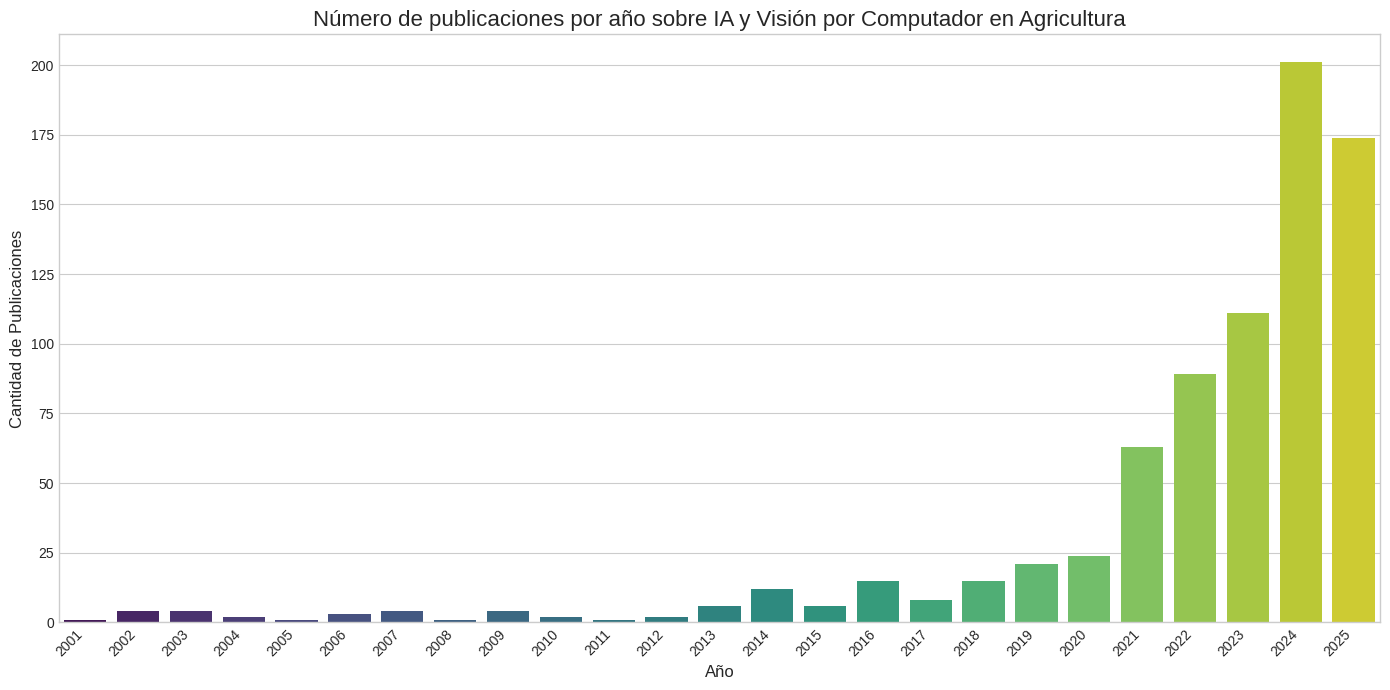

In [119]:
# Contar publicaciones por año y ordenarlas
publications_per_year = df['year'].value_counts().sort_index()

# Filtrar para mostrar desde el año 2000 para mayor claridad
publications_per_year = publications_per_year[publications_per_year.index >= 2000]

# Visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 7))
sns.barplot(x=publications_per_year.index, y=publications_per_year.values, palette="viridis")
plt.title('Número de publicaciones por año sobre IA y Visión por Computador en Agricultura', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de Publicaciones', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

/tmp/ipykernel_4065512/3052633649.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors.values, y=top_authors.index, palette="mako_r", orient='h')


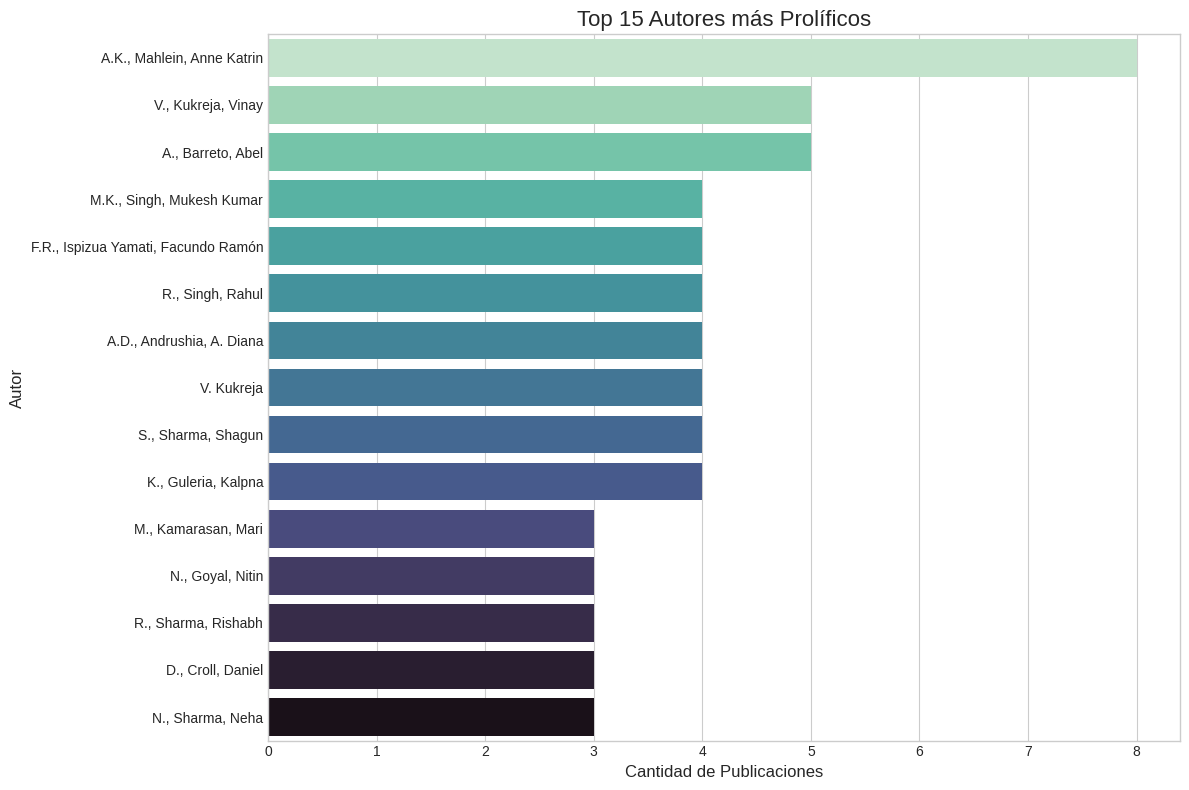

In [120]:
# Usamos 'explode' para crear una fila por cada autor en la lista 'authors_list'
authors_exploded = df.explode('authors_list')

# Contamos la frecuencia de cada autor y tomamos el top 15
top_authors = authors_exploded['authors_list'].value_counts().nlargest(15)

# Visualización
plt.figure(figsize=(12, 8))
sns.barplot(x=top_authors.values, y=top_authors.index, palette="mako_r", orient='h')
plt.title('Top 15 Autores más Prolíficos', fontsize=16)
plt.xlabel('Cantidad de Publicaciones', fontsize=12)
plt.ylabel('Autor', fontsize=12)
plt.tight_layout()
plt.show()


In [121]:
# Rellenar valores nulos en columnas clave para el análisis
df['authors'].fillna('Desconocido', inplace=True)
df['author_keywords'].fillna('', inplace=True)
df['document_type'].fillna('No especificado', inplace=True)
df['source_title'].fillna('No especificado', inplace=True)


# --- 3. Estructurar Columnas para Análisis ---
# Crear listas a partir de cadenas separadas por ';'
def split_and_clean(text, delimiter=';'):
    if not isinstance(text, str):
        return []
    return [item.strip() for item in text.split(delimiter) if item.strip()]

df['authors_list'] = df['authors'].apply(split_and_clean)
df['keywords_list'] = df['author_keywords'].apply(lambda x: [kw.lower() for kw in split_and_clean(x)])

print("\nPreparación de datos completada. ¡Listos para el EDA!")


Preparación de datos completada. ¡Listos para el EDA!


/tmp/ipykernel_4065512/1145837404.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['authors'].fillna('Desconocido', inplace=True)
/tmp/ipykernel_4065512/1145837404.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['authors'].fillna('Desconocido', inplace=True)
/tmp/ipykernel_4065512/1145837404.py:3: FutureWarning: A value is trying 

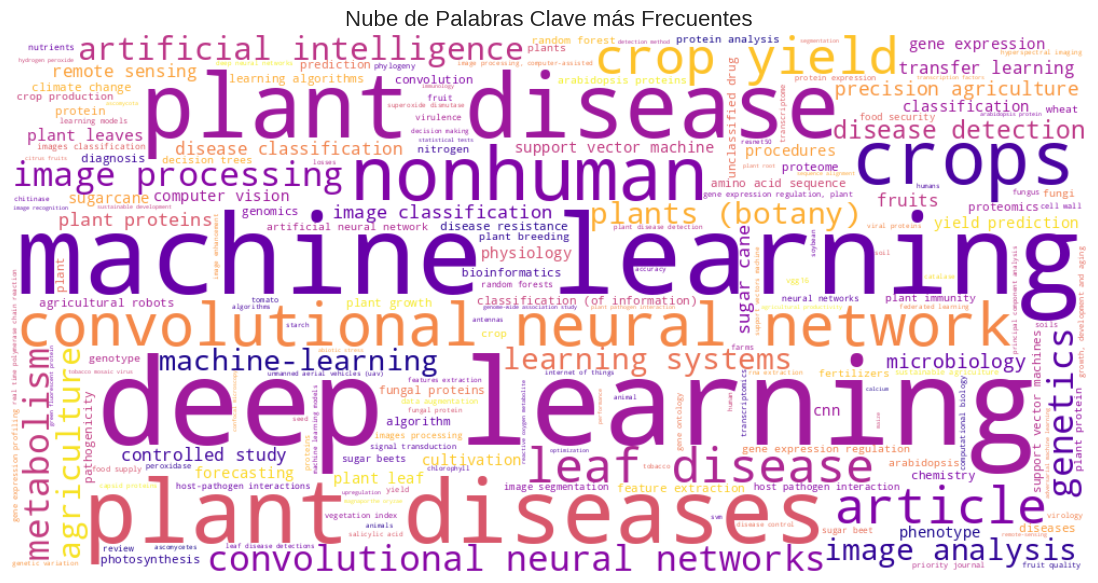

In [122]:
# Juntar todas las palabras clave en una sola lista
all_keywords = [kw for sublist in df['keywords_list'] for kw in sublist]

# Contar la frecuencia de cada palabra clave
keyword_counts = Counter(all_keywords)

# Generar la nube de palabras



wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='plasma').generate_from_frequencies(keyword_counts)

# Visualización
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras Clave más Frecuentes', fontsize=16)
plt.show()


/tmp/ipykernel_4065512/2708844536.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sources.values, y=top_sources.index, palette="rocket_r", orient='h')


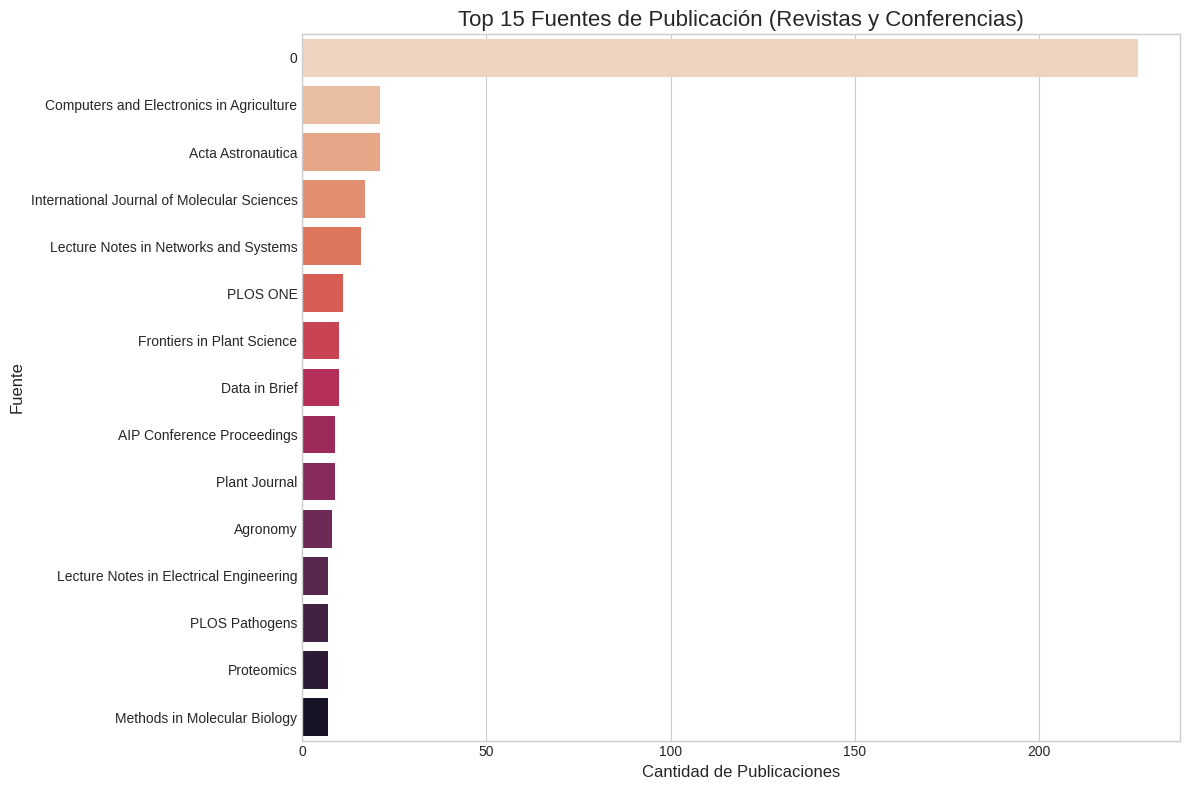

In [123]:
# Contar publicaciones por fuente y tomar el top 15
top_sources = df['source_title'].value_counts().nlargest(15)

# Visualización
plt.figure(figsize=(12, 8))
sns.barplot(x=top_sources.values, y=top_sources.index, palette="rocket_r", orient='h')
plt.title('Top 15 Fuentes de Publicación (Revistas y Conferencias)', fontsize=16)
plt.xlabel('Cantidad de Publicaciones', fontsize=12)
plt.ylabel('Fuente', fontsize=12)
plt.tight_layout()
plt.show()


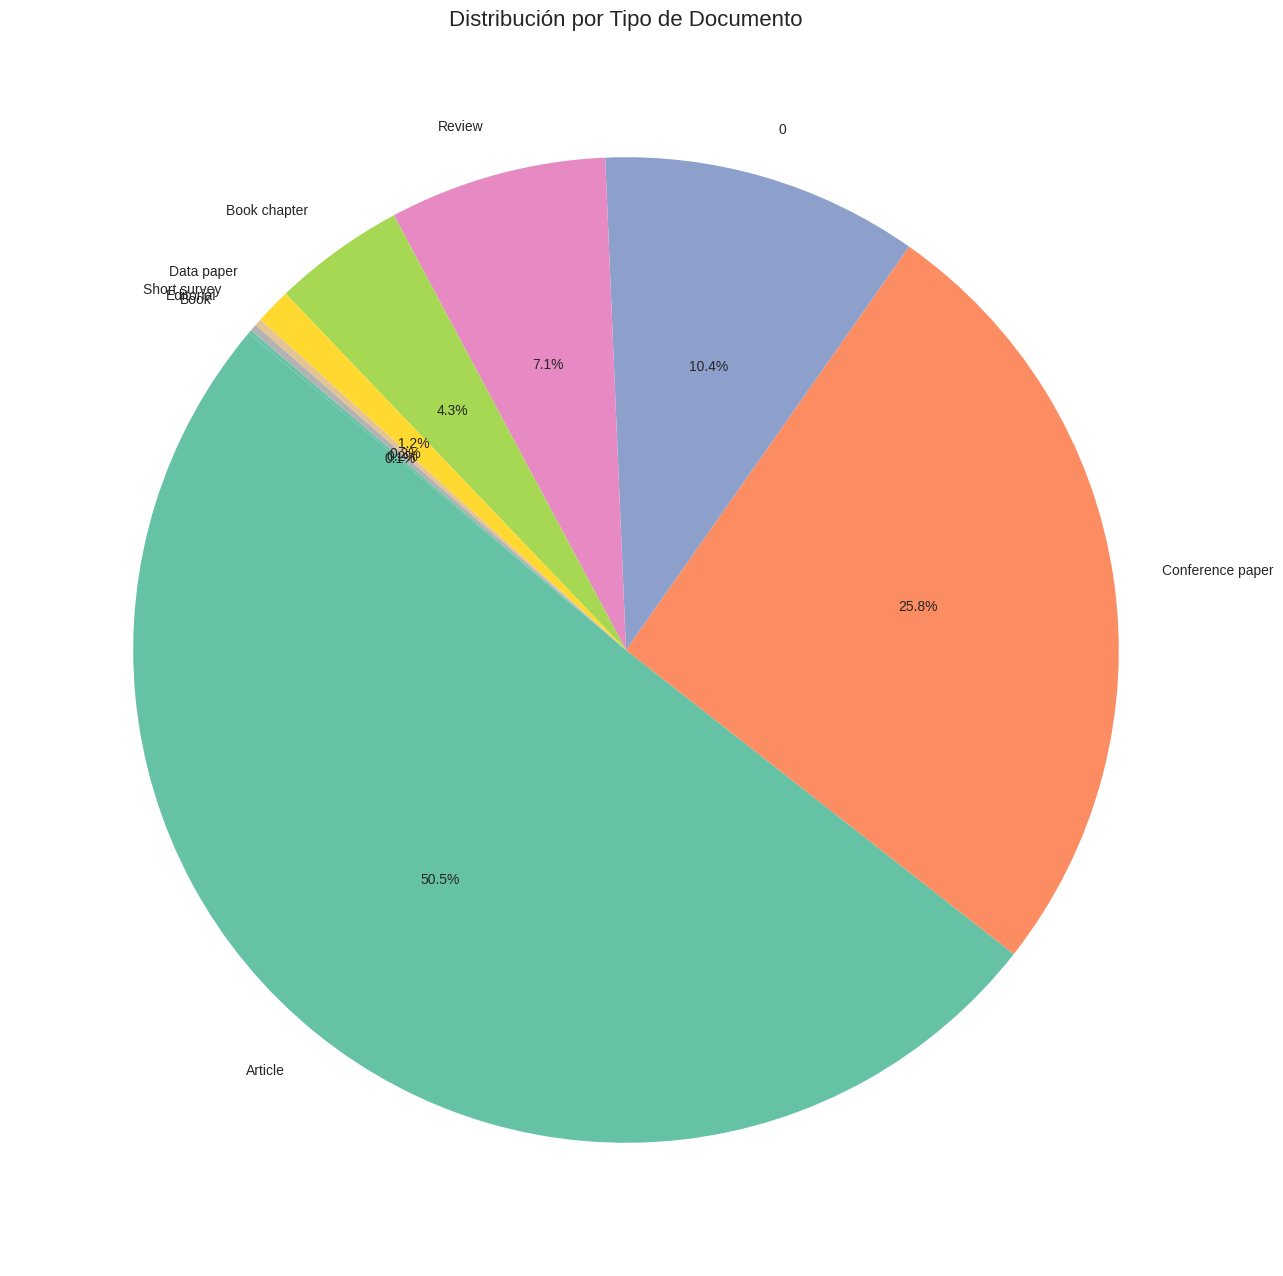

In [124]:
# Contar la frecuencia de cada tipo de documento
doc_types = df['document_type'].value_counts()

# Visualización
plt.figure(figsize=(24, 16))
plt.pie(doc_types, labels=doc_types.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
plt.title('Distribución por Tipo de Documento', fontsize=16)
plt.ylabel('') # Ocultar la etiqueta del eje y
plt.show()


In [125]:
# Lista para almacenar todas las aristas (pares de co-autores)
edge_list = []

# Iterar sobre cada lista de autores en el DataFrame
for authors in df['authors_list']:
    # Solo nos interesan las publicaciones con 2 o más autores
    if len(authors) > 1:
        # Generar todas las combinaciones de 2 autores
        # Usamos sorted() para que el par (Autor A, Autor B) sea igual a (Autor B, Autor A)
        links = combinations(sorted(authors), 2)
        edge_list.extend(links)

# Contar la frecuencia de cada colaboración (el peso de cada arista)
collaboration_counts = Counter(edge_list)

print(f"Se encontraron {len(collaboration_counts)} colaboraciones únicas.")
print("\nTop 10 colaboraciones más fuertes:")
print(collaboration_counts.most_common(10))


Se encontraron 9914 colaboraciones únicas.

Top 10 colaboraciones más fuertes:
[(('A., Barreto, Abel', 'A.K., Mahlein, Anne Katrin'), 5), (('A.K., Mahlein, Anne Katrin', 'F.R., Ispizua Yamati, Facundo Ramón'), 4), (('K., Guleria, Kalpna', 'S., Sharma, Shagun'), 4), (('A., Barreto, Abel', 'F.R., Ispizua Yamati, Facundo Ramón'), 3), (('A.K., Mahlein, Anne Katrin', 'C., Bauckhage, Christian'), 3), (('A.K., Mahlein, Anne Katrin', 'M., Gunder, Maurice'), 3), (('F.R., Ispizua Yamati, Facundo Ramón', 'M., Gunder, Maurice'), 3), (('M.K., Singh, Mukesh Kumar', 'V.K., Gupta, Vishan Kumar'), 3), (('A., Trephena Patricia, A.', 'A.D., Andrushia, A. Diana'), 3), (('C., Senthilkumar, C.', 'M., Kamarasan, Mari'), 3)]


In [126]:
# Crear un grafo vacío
G = nx.Graph()

# Añadir las aristas con su peso (número de colaboraciones)
for (author1, author2), count in collaboration_counts.items():
    G.add_edge(author1, author2, weight=count)

print(f"\nGrafo creado con {G.number_of_nodes()} nodos (autores) y {G.number_of_edges()} aristas (colaboraciones).")



Grafo creado con 3806 nodos (autores) y 9914 aristas (colaboraciones).


In [127]:
# --- Filtrar para mantener solo el núcleo de la red ---
# 1. Calcular el número de publicaciones de cada autor
all_authors = [author for sublist in df['authors_list'] for author in sublist]
author_counts = Counter(all_authors)

# 2. Seleccionar los N autores más prolíficos (ej. top 50)
N_TOP_AUTHORS = 50
top_authors_list = [author for author, count in author_counts.most_common(N_TOP_AUTHORS)]

# 3. Crear un subgrafo que solo contenga a estos autores y las conexiones entre ellos
core_graph = G.subgraph(top_authors_list)

# 4. (Opcional pero recomendado) Mantener solo el componente conectado más grande para una mejor visualización
largest_cc = max(nx.connected_components(core_graph), key=len)
final_graph = core_graph.subgraph(largest_cc)

print(f"\nSubgrafo final para visualización con {final_graph.number_of_nodes()} autores y {final_graph.number_of_edges()} colaboraciones.")



Subgrafo final para visualización con 5 autores y 4 colaboraciones.


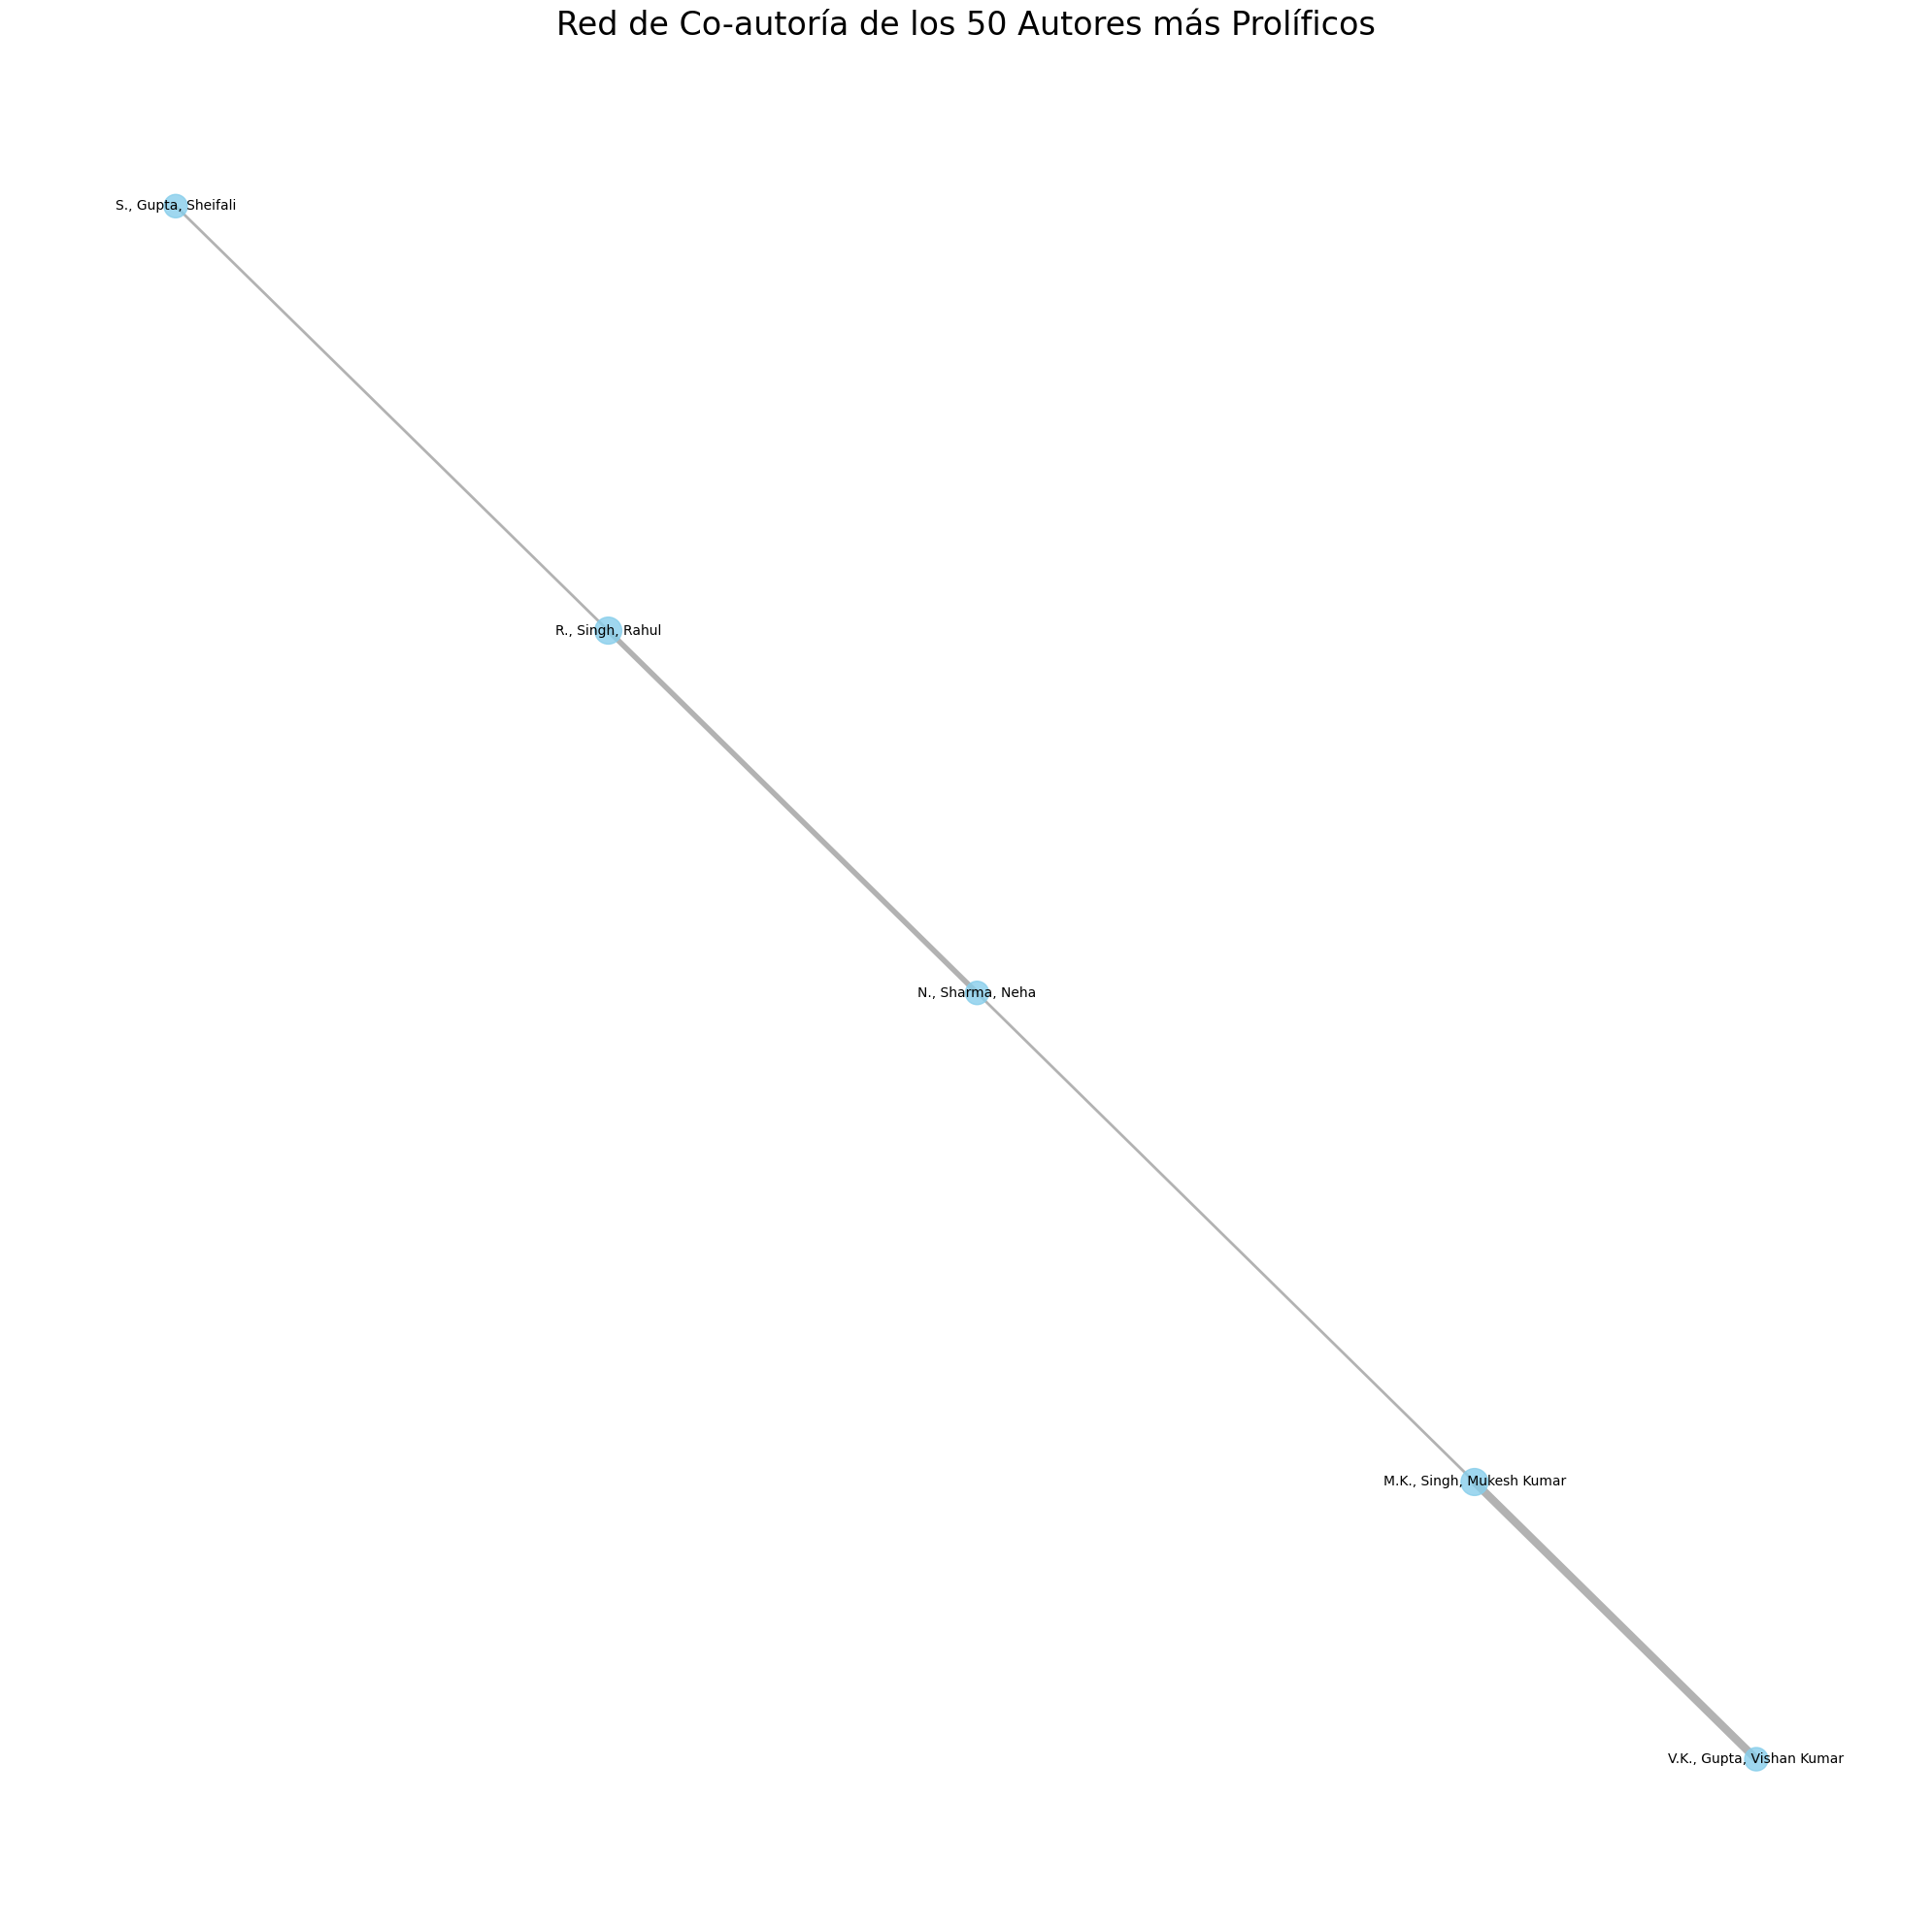

In [128]:
plt.style.use('default')
plt.figure(figsize=(20, 20))

# --- Posicionamiento de los nodos ---
# El layout "spring" simula una repulsión entre nodos y una atracción por las aristas
pos = nx.spring_layout(final_graph, k=0.6, iterations=50, seed=42)

# --- Dibujar los nodos ---
# El tamaño del nodo será proporcional a su número de publicaciones
node_sizes = [author_counts[node] * 100 for node in final_graph.nodes()]
nx.draw_networkx_nodes(final_graph, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)

# --- Dibujar las aristas ---
# El grosor de la arista será proporcional al número de colaboraciones
edge_weights = [final_graph[u][v]['weight'] * 2 for u, v in final_graph.edges()]
nx.draw_networkx_edges(final_graph, pos, width=edge_weights, edge_color='gray', alpha=0.6)

# --- Dibujar las etiquetas (nombres de los autores) ---
nx.draw_networkx_labels(final_graph, pos, font_size=10, font_family='sans-serif')

# --- Títulos y configuración del gráfico ---
plt.title('Red de Co-autoría de los 50 Autores más Prolíficos', fontsize=24)
plt.axis('off') # Ocultar los ejes
plt.tight_layout()
plt.show()


In [129]:
# Seleccionar y combinar las columnas de texto. Rellenar nulos con ''
df['title'] = df['title'].fillna('')
df['abstract'] = df['abstract'].fillna('')
df['documents'] = df['title'] + '. ' + df['abstract']

print(f"Dataset preparado con {len(df)} documentos únicos para el análisis LDA.")
print("\nEjemplo de documento combinado:")
print(df['documents'].iloc[1])

Dataset preparado con 855 documentos únicos para el análisis LDA.

Ejemplo de documento combinado:
Enhancing yield and protein content estimation in dry peas through multispectral data integration and ensemble learning model. Accurately predicting yield and protein content in dry peas (Pisum sativum L.) is essential for improving agricultural productivity, sustainability, and nutritional outcomes. Traditional methods for estimating these traits are labor-intensive and limited in scope, while remote sensing technologies and machine learning offer scalable, nondestructive alternatives. This study addresses the challenge of integrating multispectral data and advanced machine learning models, specifically stacked meta-models, to enhance prediction accuracy for yield and protein content in dry peas. Data were collected from 860 genotypes across two North Dakota locations over three growing seasons using uncrewed aerial system-mounted multispectral sensors. The results revealed significant v

/tmp/ipykernel_4065512/3083154805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = df['title'].fillna('')
/tmp/ipykernel_4065512/3083154805.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['abstract'] = df['abstract'].fillna('')
/tmp/ipykernel_4065512/3083154805.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [137]:
nltk.download('wordnet')
# --- 2. Pre-procesamiento de Texto ---

# Inicializar lemmatizer y stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Añadir stopwords personalizadas que son muy comunes en este dominio
# y que no aportan a la diferenciación de tópicos.
custom_stopwords = {
    # Palabras muy generales de investigación
    'study', 'research', 'paper', 'article', 'approach', 'method', 
    'technique', 'result', 'analysis', 'using', 'based', 'propose',
    
    # Términos genéricos de IA que no discriminan
    'artificial', 'intelligence', 'ai', 'machine', 'learning', 
    'deep', 'neural', 'network', 'cnn', 'algorithm', 'model',

    # Palabras frecuentes en visión por computador que no aportan contexto
    'image', 'images', 'processing', 'recognition', 'detection',
    'classification', 'segmentation', 'computer', 'vision',

    # Agricultura genérica
    'agriculture', 'agricultural', 'crop', 'crops', 'plant', 'plants', 
    'leaf', 'leaves', 'disease', 'diseases', 'foliar', 'pathology',

    # Nutrición muy genérica
    'nutritional', 'nutrition', 'composition', 'content', 
    'macronutrients', 'micronutrients', 'minerals', 'vitamins',
}
stop_words.update(custom_stopwords)

def preprocess_text(text):
    # 1. Convertir a minúsculas
    text = text.lower()
    # 2. Eliminar caracteres no alfabéticos (puntuación, números, etc.)
    text = re.sub(r'[^a-z\s]', '', text)
    # 3. Tokenizar (dividir el texto en palabras)
    tokens = text.split()
    # 4. Lemmatizar y eliminar stopwords y palabras cortas
    lemmatized_tokens = [
        lemmatizer.lemmatize(token) for token in tokens 
        if token not in stop_words and len(token) > 2
    ]
    return lemmatized_tokens

# Aplicar la función de pre-procesamiento a todos los documentos
processed_docs = df['documents'].map(preprocess_text)

print("\nEjemplo de documento procesado (tokenizado y lemmatizado):")
print(processed_docs.iloc[1])


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/aalejoz25/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Ejemplo de documento procesado (tokenizado y lemmatizado):
['enhancing', 'yield', 'protein', 'estimation', 'dry', 'pea', 'multispectral', 'data', 'integration', 'ensemble', 'accurately', 'predicting', 'yield', 'protein', 'dry', 'pea', 'pisum', 'sativum', 'essential', 'improving', 'productivity', 'sustainability', 'outcome', 'traditional', 'method', 'estimating', 'trait', 'laborintensive', 'limited', 'scope', 'remote', 'sensing', 'technology', 'offer', 'scalable', 'nondestructive', 'alternative', 'address', 'challenge', 'integrating', 'multispectral', 'data', 'advanced', 'model', 'specifically', 'stacked', 'metamodels', 'enhance', 'prediction', 'accuracy', 'yield', 'protein', 'dry', 'pea', 'data', 'collected', 'genotype', 'across', 'two', 'north', 'dakota', 'location', 'three', 'growing', 'season', 'uncrewed', 'aerial', 'systemmounted', 'multispectral', 'sensor', 'result', 'revealed', 'significant', 'variability', 'yield', 'protein', 'due', 'location', 'year', 'metamodel', 'outperformi

In [138]:
# --- 3. Crear Diccionario y Corpus ---

# Crear un diccionario a partir de los documentos procesados
# El diccionario mapea cada palabra a un ID único.
dictionary = Dictionary(processed_docs)

# Filtrar palabras extremas:
# - no_below: ignora palabras que aparecen en menos de 5 documentos.
# - no_above: ignora palabras que aparecen en más del 50% de los documentos.
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Crear el corpus (Bolsa de Palabras)
# Convierte cada documento en una lista de tuplas (word_id, frequency).
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

print(f"\nDiccionario creado con {len(dictionary)} palabras únicas.")
print("Ejemplo de un documento en formato BoW (ID de palabra, frecuencia):")
print(corpus[1][:10]) # Muestra los primeros 10 pares



Diccionario creado con 2766 palabras únicas.
Ejemplo de un documento en formato BoW (ID de palabra, frecuencia):
[(0, 2), (1, 1), (14, 5), (40, 1), (50, 1), (52, 3), (63, 1), (68, 1), (75, 1), (76, 1)]


In [139]:
# --- 4. Construir el Modelo LDA ---

# Definir el número de tópicos a descubrir
num_topics = 8

# Construir el modelo LDA
# passes: número de veces que el modelo itera sobre todo el corpus.
# iterations: número de iteraciones por documento.
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

print(f"\nModelo LDA entrenado con {num_topics} tópicos.")
print("\nTópicos descubiertos (palabras clave por tópico):")
for idx, topic in lda_model.print_topics(-1):
    print(f"Tópico: {idx+1} \nPalabras: {topic}\n")



Modelo LDA entrenado con 8 tópicos.

Tópicos descubiertos (palabras clave por tópico):
Tópico: 1 
Palabras: 0.028*"feature" + 0.021*"accuracy" + 0.017*"proposed" + 0.013*"cassava" + 0.012*"used" + 0.011*"citrus" + 0.011*"result" + 0.010*"performance" + 0.010*"spot" + 0.010*"dataset"

Tópico: 2 
Palabras: 0.040*"system" + 0.024*"mission" + 0.019*"beet" + 0.018*"sensor" + 0.017*"sugar" + 0.015*"data" + 0.012*"control" + 0.011*"technology" + 0.011*"iot" + 0.010*"propulsion"

Tópico: 3 
Palabras: 0.010*"farmer" + 0.010*"production" + 0.009*"system" + 0.009*"technique" + 0.008*"accuracy" + 0.008*"model" + 0.008*"various" + 0.008*"quality" + 0.007*"data" + 0.007*"food"

Tópico: 4 
Palabras: 0.041*"yield" + 0.027*"soil" + 0.016*"prediction" + 0.015*"data" + 0.012*"model" + 0.009*"used" + 0.008*"sugarcane" + 0.008*"root" + 0.008*"growth" + 0.008*"value"

Tópico: 5 
Palabras: 0.033*"space" + 0.024*"seed" + 0.023*"trait" + 0.022*"genetic" + 0.020*"breeding" + 0.019*"genotype" + 0.018*"program" 

In [140]:
# --- 5. Visualización de los Tópicos ---

# Habilitar el formateador de pyLDAvis para notebooks (si usas uno)
pyLDAvis.enable_notebook()

# Preparar los datos para la visualización
# NOTA: El cálculo puede tardar unos minutos en datasets grandes.
vis_data = gensimvis.prepare(lda_model, corpus, dictionary, mds='mmds')

# Guardar la visualización en un archivo HTML
output_filepath = './LDA_resultados.html'
pyLDAvis.save_html(vis_data, output_filepath)

print(f"\n¡Visualización LDA guardada en '{output_filepath}'!")
print("Abre este archivo en tu navegador para explorar los tópicos de forma interactiva.")

# Mostrar la visualización directamente (si estás en un Jupyter Notebook/Lab)
vis_data



¡Visualización LDA guardada en './LDA_resultados.html'!
Abre este archivo en tu navegador para explorar los tópicos de forma interactiva.


/home/aalejoz25/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.014687  0.041840       1        1  30.719236
3      0.080957  0.296802       2        1  20.576340
0      0.292644  0.159614       3        1  16.151823
5      0.320071 -0.129965       4        1  12.902376
7     -0.335525 -0.004172       5        1   7.365505
1     -0.224663  0.304149       6        1   6.356627
4      0.101838 -0.360595       7        1   3.020386
6     -0.220636 -0.307672       8        1   2.907707, topic_info=          Term        Freq       Total Category  logprob  loglift
309      fruit  446.000000  446.000000  Default  30.0000  30.0000
163    protein  623.000000  623.000000  Default  29.0000  29.0000
96       yield  955.000000  955.000000  Default  28.0000  28.0000
537     system  538.000000  538.000000  Default  27.0000  27.0000
454       soil  511.000000  511.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1099     since   17.733691   47.872816   Topic8  -5.0181   2.5447
1346    sample   18.002556  107.582300   Topic8  -5.0030   1.7501
537     system   20.593113  538.833351   Topic8  -4.8686   0.2734
57    nutrient   19.180601  252.343800   Topic8  -4.9396   0.9609
89        used   18.523992  539.608835   Topic8  -4.9745   0.1660

[475 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1316      5  0.970856   abiotic
1734      5  0.976287      able
0         1  0.396983  accuracy
0         2  0.074746  accuracy
0         3  0.526543  accuracy
...     ...       ...       ...
96        1  0.148665     yield
96        2  0.810327     yield
96        3  0.019892     yield
96        5  0.020939     yield
582       8  0.956140     yolov

[815 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 6, 8, 2, 5, 7])

/tmp/ipykernel_4065512/676765296.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dominant_topic'] = [get_dominant_topic(corpus[i]) for i in range(len(corpus))]


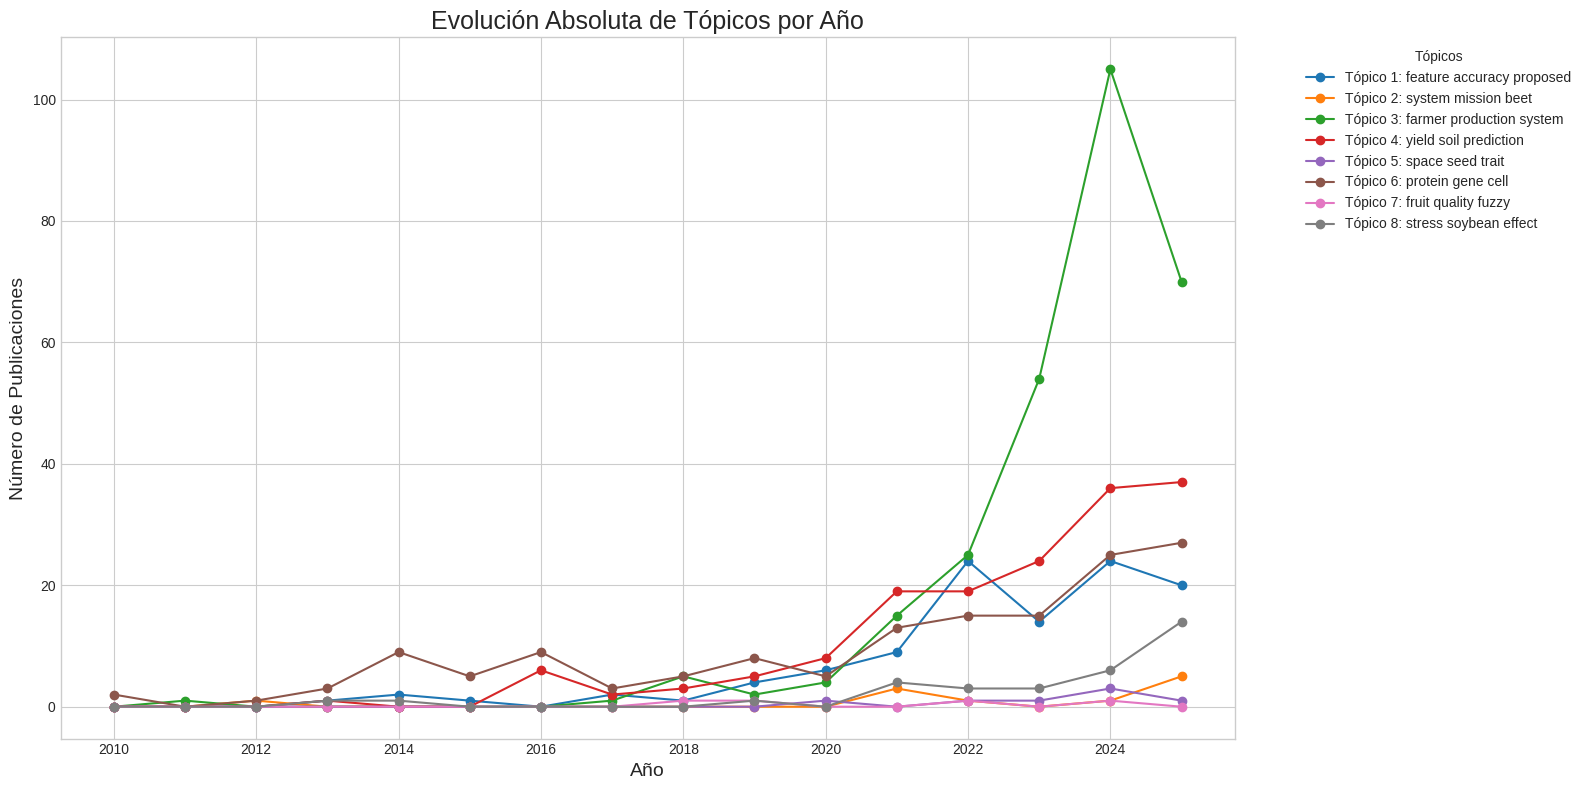

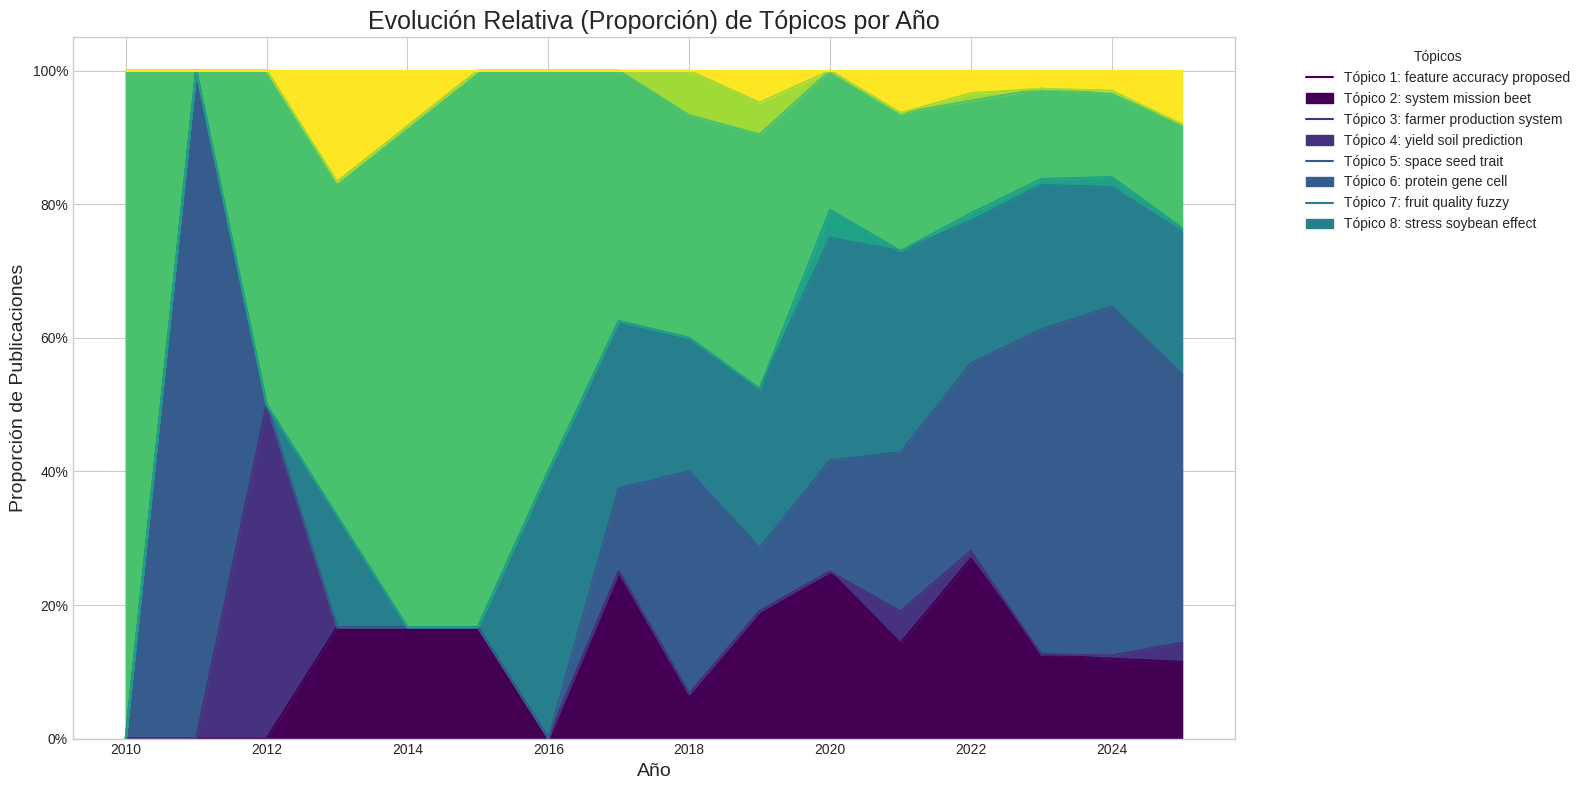

In [141]:
# --- 3. Asignar Tópico Dominante a cada Documento ---
def get_dominant_topic(bow):
    # Obtener la distribución de tópicos para un documento
    topic_distribution = lda_model.get_document_topics(bow, minimum_probability=0.0)
    # Ordenar por probabilidad y obtener el tópico con la más alta
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0]
    return dominant_topic[0]

# Crear una nueva columna en el DataFrame con el tópico dominante
# Asegurarse de que los índices coincidan después de haber eliminado filas nulas
df['dominant_topic'] = [get_dominant_topic(corpus[i]) for i in range(len(corpus))]

# --- 4. Agrupar por Año y Tópico ---
# Filtrar por un rango de años para una mejor visualización (ej. desde el 2010)
df_filtered = df[df['year'] >= 2010]

# Agrupar por año y tópico dominante, y contar el número de documentos
topic_counts_per_year = df_filtered.groupby(['year', 'dominant_topic']).size().unstack(fill_value=0)

# --- 5. Visualizar la Evolución de los Tópicos ---

# Gráfico 1: Evolución de la popularidad absoluta (número de publicaciones)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 8))
topic_counts_per_year.plot(ax=ax, marker='o', linestyle='-')

# Crear etiquetas de leyenda más descriptivas
topic_keywords = [" ".join([word for word, _ in lda_model.show_topic(i, topn=3)]) for i in range(num_topics)]
legend_labels = [f'Tópico {i+1}: {topic_keywords[i]}' for i in range(num_topics)]

ax.set_title('Evolución Absoluta de Tópicos por Año', fontsize=18)
ax.set_xlabel('Año', fontsize=14)
ax.set_ylabel('Número de Publicaciones', fontsize=14)
ax.legend(legend_labels, title='Tópicos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Gráfico 2: Evolución de la popularidad relativa (proporción de publicaciones)
# Normalizar los datos para que cada fila sume 1 (100%)
topic_proportions = topic_counts_per_year.div(topic_counts_per_year.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(16, 8))
topic_proportions.plot(kind='area', stacked=True, ax=ax, colormap='viridis')

ax.set_title('Evolución Relativa (Proporción) de Tópicos por Año', fontsize=18)
ax.set_xlabel('Año', fontsize=14)
ax.set_ylabel('Proporción de Publicaciones', fontsize=14)
ax.legend(legend_labels, title='Tópicos', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format)) # Formatear eje Y como porcentaje
plt.tight_layout()
plt.show()

/tmp/ipykernel_4065512/2209781293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keywords_list'] = df['author_keywords'].apply(split_and_clean)


Datos listos para la creación de la red de co-ocurrencia de palabras clave.

Se encontraron 251717 pares de co-ocurrencia únicos.

Top 10 co-ocurrencias más fuertes:
[(('convolutional neural network', 'deep learning'), 150), (('deep learning', 'deep learning'), 140), (('deep learning', 'leaf disease'), 140), (('plant disease', 'plant diseases'), 137), (('machine learning', 'machine learning'), 125), (('convolutional neural networks', 'deep learning'), 116), (('deep learning', 'plant disease'), 110), (('article', 'nonhuman'), 109), (('crop yield', 'machine learning'), 109), (('machine learning', 'machine-learning'), 103)]

Grafo final para visualización con 40 nodos y 705 aristas.


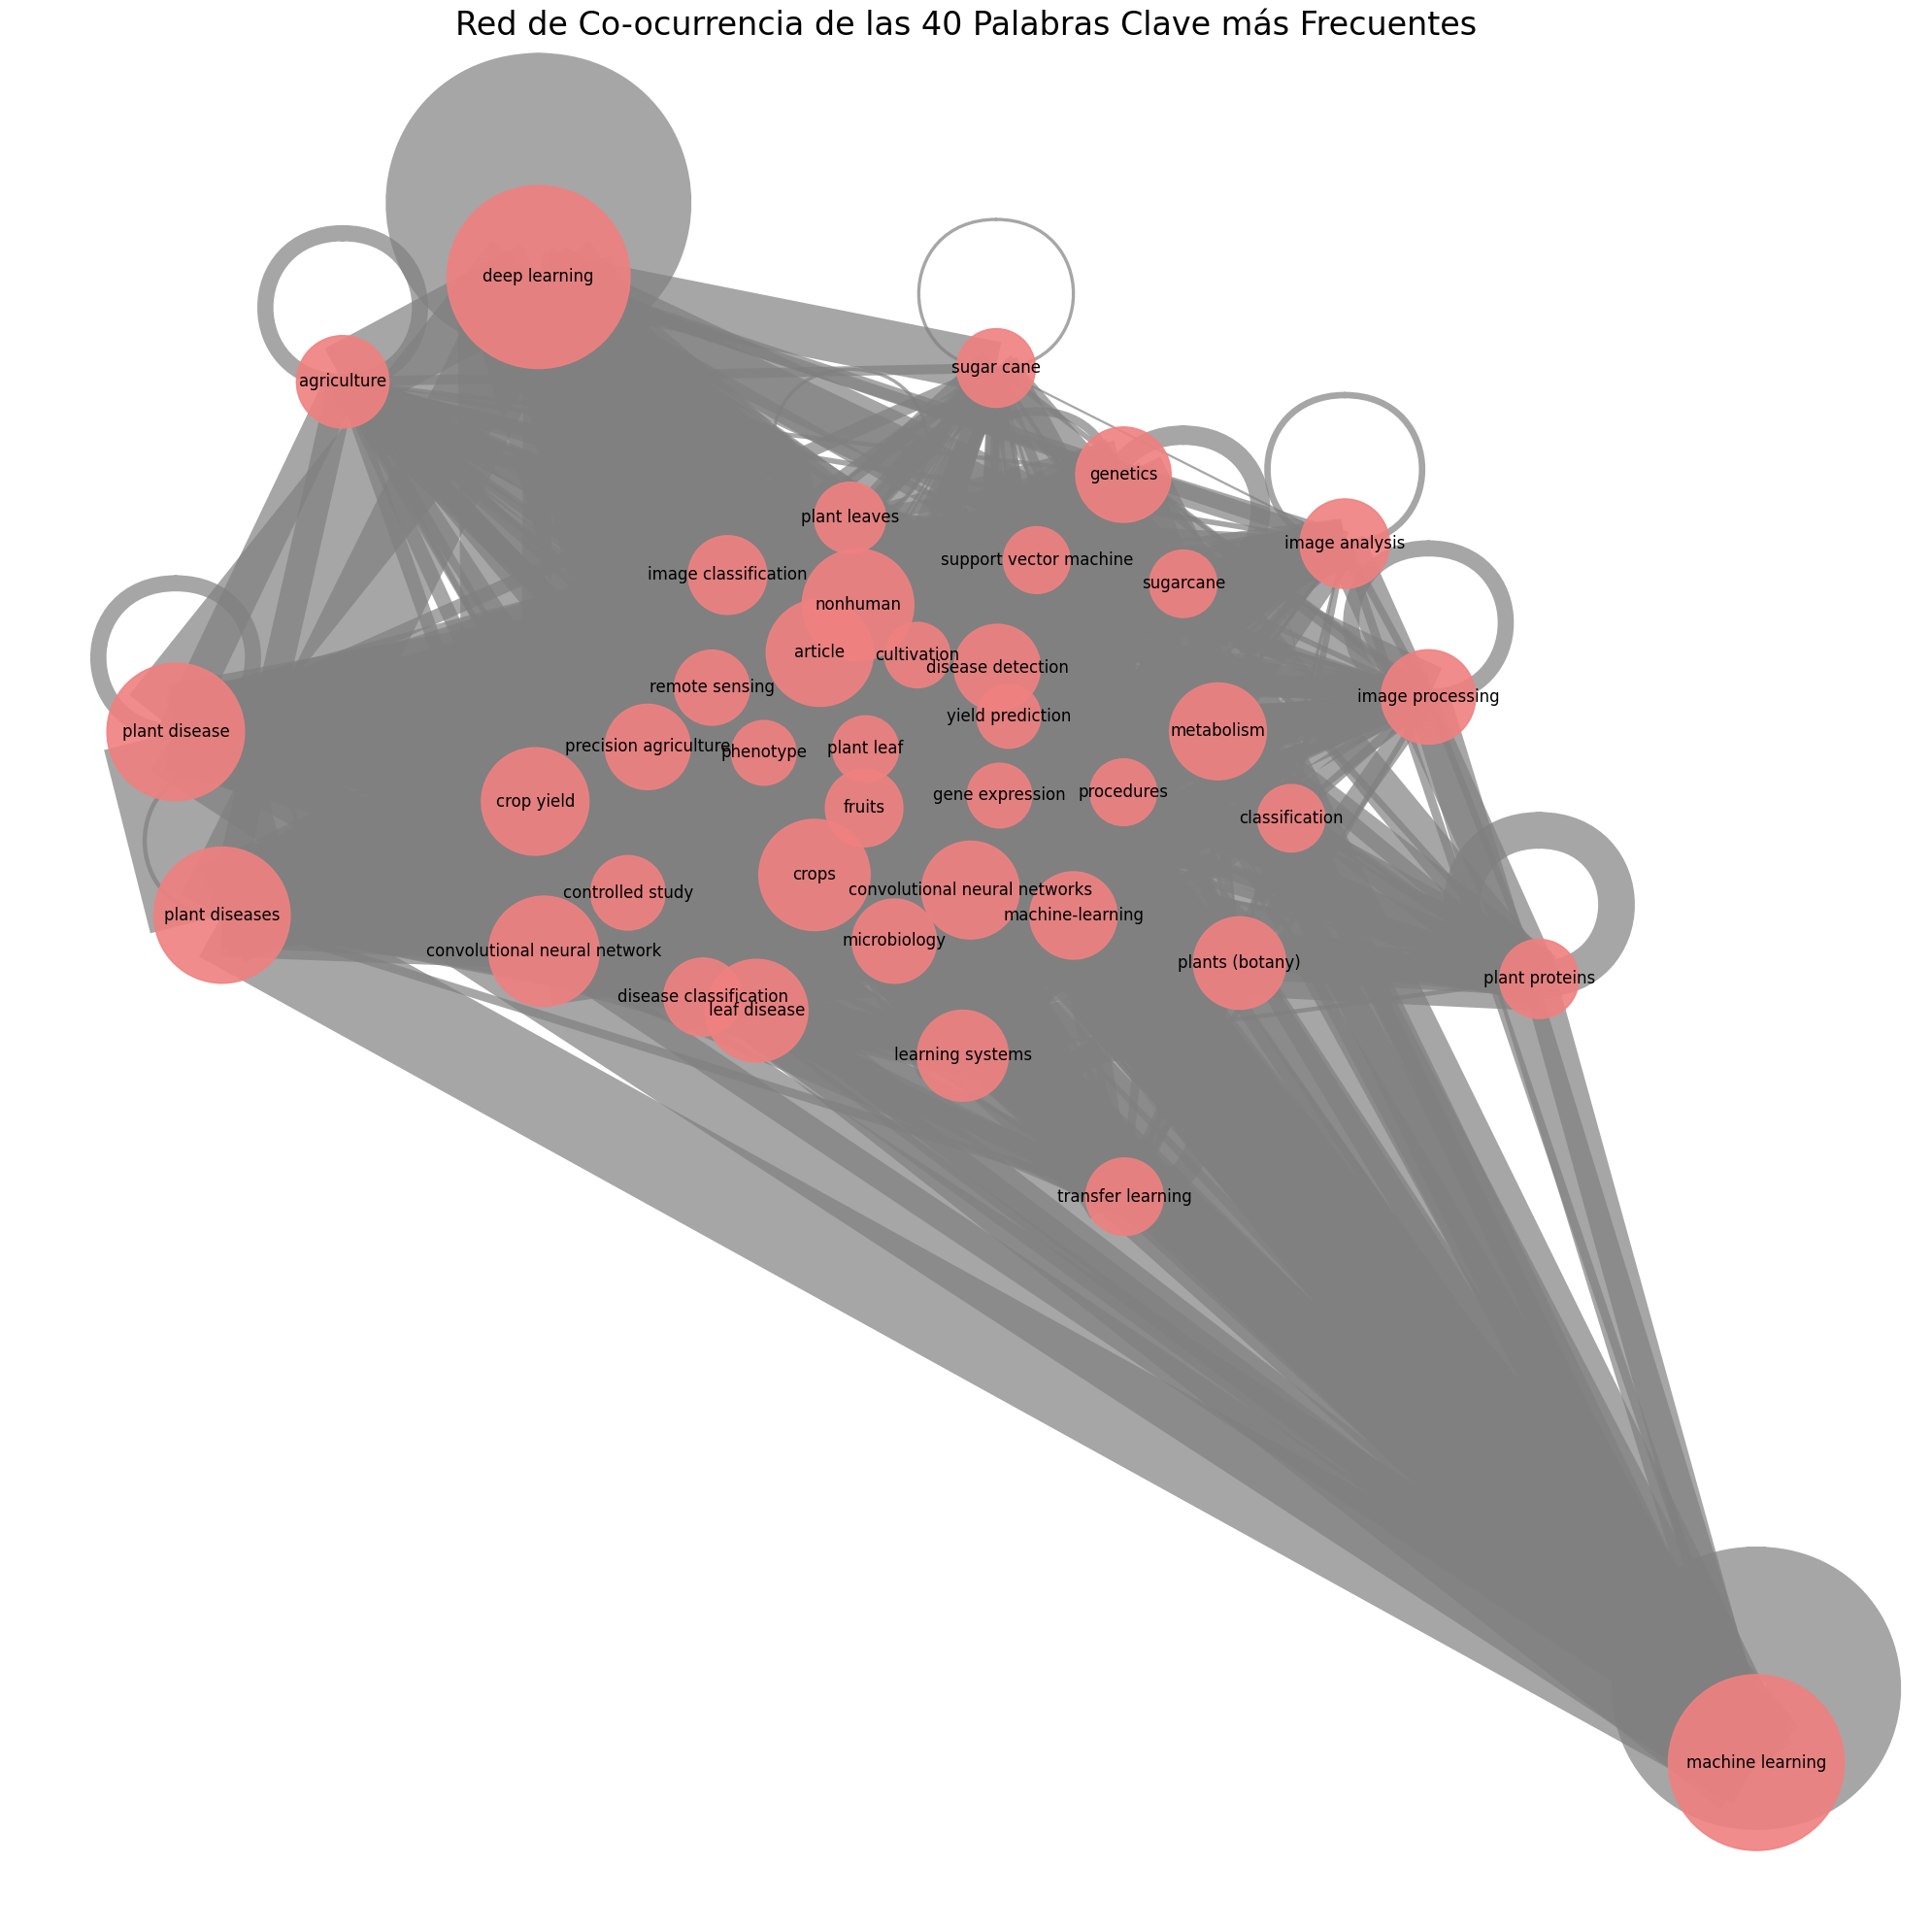

In [135]:
# --- 2. Procesamiento de Palabras Clave ---
def split_and_clean(text, delimiter=';'):
    if not isinstance(text, str):
        return []
    # Limpiamos, convertimos a minúsculas y eliminamos palabras clave genéricas
    keywords = [item.strip().lower() for item in text.split(delimiter) if item.strip()]
    # Filtramos palabras clave muy genéricas que no aportan valor a la red
    generic_kws = {'software testing', 'artificial intelligence', 'ai', 'software engineering'}
    return [kw for kw in keywords if kw not in generic_kws]

df['keywords_list'] = df['author_keywords'].apply(split_and_clean)

print("Datos listos para la creación de la red de co-ocurrencia de palabras clave.")

# --- 3. Generación de Pares de Co-ocurrencia ---
# Lista para almacenar todos los pares de palabras clave que co-ocurren
co_occurrence_pairs = []

for keywords in df['keywords_list']:
    # Solo nos interesan publicaciones con 2 o más palabras clave
    if len(keywords) > 1:
        # Generar todas las combinaciones de 2 palabras clave
        # Usamos sorted() para que el par (A, B) sea igual a (B, A)
        links = combinations(sorted(keywords), 2)
        co_occurrence_pairs.extend(links)

# Contar la frecuencia de cada par (el peso de cada arista)
pair_counts = Counter(co_occurrence_pairs)

print(f"\nSe encontraron {len(pair_counts)} pares de co-ocurrencia únicos.")
print("\nTop 10 co-ocurrencias más fuertes:")
print(pair_counts.most_common(10))

# --- 4. Filtrado y Construcción del Grafo ---
# Contar la frecuencia de cada palabra clave individualmente
all_keywords = [kw for sublist in df['keywords_list'] for kw in sublist]
keyword_counts = Counter(all_keywords)

# Seleccionar las N palabras clave más frecuentes (ej. top 40)
N_TOP_KEYWORDS = 40
top_keywords_list = [kw for kw, count in keyword_counts.most_common(N_TOP_KEYWORDS)]

# Crear el grafo
G = nx.Graph()

# Añadir nodos y aristas ponderadas para las palabras clave del top
for (kw1, kw2), weight in pair_counts.items():
    if kw1 in top_keywords_list and kw2 in top_keywords_list:
        G.add_node(kw1, size=keyword_counts[kw1])
        G.add_node(kw2, size=keyword_counts[kw2])
        G.add_edge(kw1, kw2, weight=weight)

print(f"\nGrafo final para visualización con {G.number_of_nodes()} nodos y {G.number_of_edges()} aristas.")

# --- 5. Visualización de la Red ---
plt.style.use('default')
plt.figure(figsize=(20, 20))

# Layout para posicionar los nodos
pos = nx.kamada_kawai_layout(G)

# Tamaños de los nodos proporcionales a su frecuencia
node_sizes = [data['size'] * 50 for node, data in G.nodes(data=True)]

# Grosor de las aristas proporcional a su peso (frecuencia de co-ocurrencia)
edge_widths = [d['weight'] * 0.8 for (u, v, d) in G.edges(data=True)]

# Dibujar la red
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightcoral', alpha=0.9)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='grey', alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

plt.title('Red de Co-ocurrencia de las 40 Palabras Clave más Frecuentes', fontsize=24)
plt.axis('off')
plt.tight_layout()
plt.show()

In [136]:
# --- 3. Asignar Tópico Dominante a cada Documento ---
def get_dominant_topic_for_doc(doc_bow):
    # Obtener la distribución de tópicos para un documento
    topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    # Encontrar el tópico con la probabilidad más alta
    dominant_topic = max(topic_distribution, key=lambda x: x[1])
    return dominant_topic[0] # Devolver solo el ID del tópico

# Aplicar la función a todo el corpus para obtener el tópico dominante de cada documento
dominant_topics = [get_dominant_topic_for_doc(doc) for doc in corpus]

# Añadir la columna de tópico dominante al DataFrame
df['dominant_topic'] = dominant_topics

print("Asignación completada. Mostrando DOIs por tópico:")

# --- 4. Mostrar DOIs y Títulos para cada Tópico ---
for topic_id in range(num_topics):
    print("\n" + "="*50)
    print(f"TÓPICO #{topic_id + 1}")
    print("="*50)
    
    # Obtener y mostrar las palabras clave del tópico
    keywords = lda_model.show_topic(topic_id, topn=10)
    topic_keywords = ", ".join([word for word, prop in keywords])
    print(f"Palabras Clave: {topic_keywords}\n")
    
    # Filtrar el DataFrame para este tópico y mostrar una muestra
    topic_df = df[df['dominant_topic'] == topic_id]
    
    # Tomar una muestra de hasta 5 artículos para no saturar la salida
    sample_size = min(5, len(topic_df))
    if sample_size > 0:
        sample_articles = topic_df.sample(n=sample_size, random_state=42)
        print("Artículos de ejemplo en este tópico:")
        for index, row in sample_articles.iterrows():
            print(f"  - DOI: {row['DOI']}")
            print(f"    Título: {row['title']}")
    else:
        print("No se encontraron artículos dominantes para este tópico.")

Asignación completada. Mostrando DOIs por tópico:

TÓPICO #1
Palabras Clave: system, mango, solar, data, banana, grape, mildew, measure, device, systematic

Artículos de ejemplo en este tópico:
  - DOI: 10.1109/I2CT57861.2023.10126126
    Título: An Automated Approach for Accurate Detection and Classification of Kiwi Powdery Mildew Disease
  - DOI: 10.1016/j.dib.2025.111594
    Título: Cauliflower leaf diseases: A computer vision dataset for smart agriculture
  - DOI: 10.1016/j.molp.2020.12.012
    Título: Using Interactome Big Data to Crack Genetic Mysteries and Enhance Future Crop Breeding
  - DOI: 10.1016/j.compag.2025.110784
    Título: Multimodal information fusion and precision harvesting system for fruit growth driven by flexible optoelectronic sensing and hierarchical attention networks
  - DOI: https://doi.org/10.1016/S0094-5765(99)00036-3
    Título: Space missions for SETI

TÓPICO #2
Palabras Clave: gene, expression, metabolic, response, cross, involved, recognize, kinase, r

/tmp/ipykernel_4065512/1346653641.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dominant_topic'] = dominant_topics


/tmp/ipykernel_4065512/1068742940.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=topic_distribution_counts.index, y=topic_distribution_counts.values, palette="cubehelix")
/tmp/ipykernel_4065512/1068742940.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(topic_labels, rotation=0, ha="center", fontsize=10)


[Text(0, 0, 'Tópico 1\naccuracy, feature, proposed, dataset'),
 Text(1, 0, 'Tópico 2\nprotein, cell, pathogen, effector'),
 Text(2, 0, 'Tópico 3\ngenome, review, development, open'),
 Text(3, 0, 'Tópico 4\nsystem, farmer, loss, production'),
 Text(4, 0, 'Tópico 5\nsoil, nutrient, water, used'),
 Text(5, 0, 'Tópico 6\nroot, beet, stress, growth'),
 Text(6, 0, 'Tópico 7\nprotein, gene, prediction, soybean'),
 Text(7, 0, 'Tópico 8\nspace, structure, weed, fungus'),
 Text(8, 0, 'Tópico 9\ndata, sugarcane, model, prediction'),
 Text(9, 0, 'Tópico 10\ncitrus, virus, host, protein')]

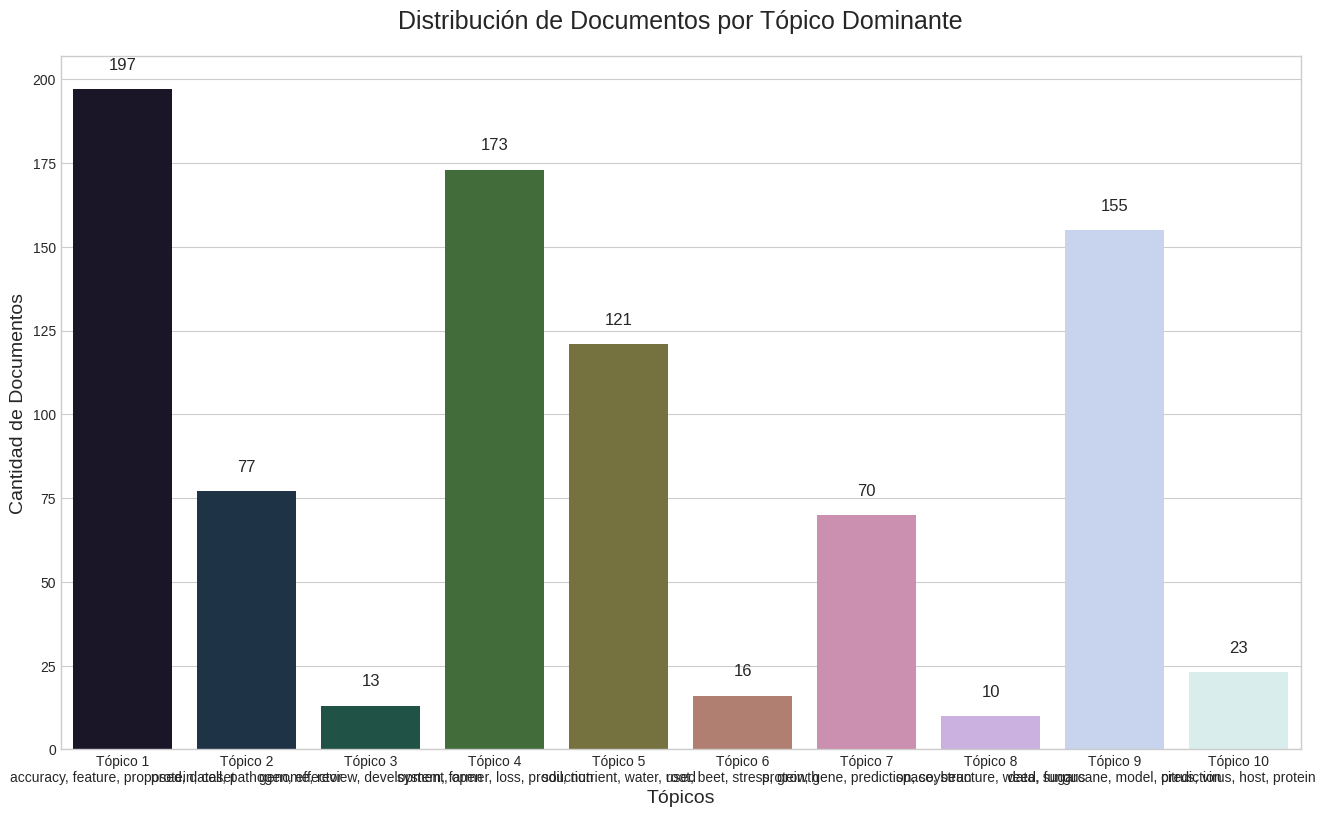

In [70]:
# --- 4. Contar Documentos por Tópico y Crear Gráfico ---

# Contar el número de documentos para cada tópico
topic_distribution_counts = df['dominant_topic'].value_counts().sort_index()

# Crear etiquetas más descriptivas para cada tópico
topic_labels = []
for i in range(num_topics):
    # Obtener las 4 palabras clave más importantes para el tópico i
    keywords = lda_model.show_topic(i, topn=4)
    # Formatear las palabras clave en una cadena
    label = f"Tópico {i+1}\n" + ", ".join([word for word, prop in keywords])
    topic_labels.append(label)

# Visualización del gráfico de barras
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 9))

ax = sns.barplot(x=topic_distribution_counts.index, y=topic_distribution_counts.values, palette="cubehelix")

# Añadir el número de documentos encima de cada barra
for index, value in enumerate(topic_distribution_counts.values):
    ax.text(index, value + 5, str(value), ha='center', va='bottom', fontsize=12)

plt.title('Distribución de Documentos por Tópico Dominante', fontsize=18, pad=20)
plt.xlabel('Tópicos', fontsize=14)
plt.ylabel('Cantidad de Documentos', fontsize=14)
ax.set_xticklabels(topic_labels, rotation=0, ha="center", fontsize=10)

In [71]:
#--- 3. Asignar Tópico Dominante y Probabilidad a cada Documento ---

def get_dominant_topic_and_prob(doc_bow):
    # Obtener la distribución de tópicos para un documento
    topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    # Encontrar el tópico con la probabilidad más alta
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0]
    topic_id = dominant_topic[0]
    topic_prob = dominant_topic[1]
    return topic_id, topic_prob

# Aplicar la función a todo el corpus para obtener el tópico dominante y su probabilidad
# Usamos zip(*...) para separar las dos listas (IDs y probabilidades)
dominant_topics, topic_probabilities = zip(*[get_dominant_topic_and_prob(doc) for doc in corpus])

# --- 4. Añadir las Nuevas Columnas al DataFrame ---
df['dominant_topic'] = dominant_topics
df['topic_probability'] = topic_probabilities

print("Columnas 'dominant_topic' y 'topic_probability' añadidas.")

# --- 5. (Opcional pero recomendado) Crear una columna con etiquetas legibles ---
# Crear un diccionario para mapear el ID del tópico a un nombre descriptivo
topic_labels = {}
for i in range(num_topics):
    # Tomar las 3 palabras clave más importantes para el tópico i
    keywords = lda_model.show_topic(i, topn=3)
    # Formatear las palabras clave en una cadena legible
    label = f"Tópico {i+1}: " + ", ".join([word for word, prop in keywords])
    topic_labels[i] = label

# Mapear los IDs a las etiquetas legibles
df['topic_label'] = df['dominant_topic'].map(topic_labels)
print("Columna 'topic_label' con nombres descriptivos añadida.")


# --- 6. Mostrar el resultado ---
print("\n--- Vista previa del DataFrame con las nuevas columnas ---")
# Mostramos las columnas relevantes para verificar el resultado
print(df[['title', 'dominant_topic', 'topic_probability', 'topic_label']].head(10))

# También puedes ver la distribución de documentos por tópico
print("\n--- Distribución de documentos por tópico ---")
print(df['topic_label'].value_counts())

Columnas 'dominant_topic' y 'topic_probability' añadidas.
Columna 'topic_label' con nombres descriptivos añadida.

--- Vista previa del DataFrame con las nuevas columnas ---
                                               title  dominant_topic  \
0  Non-invasive diagnosis of nutrient deficiencie...               4   
1  Enhancing yield and protein content estimation...               8   
2  Integrated phenotypic analysis, predictive mod...               6   
3  3-Methyl pentanoic acid suppress gray mold dis...               1   
4  Performance optimization of pneumatic precisio...               0   
5  Estimation of NPK from soil data using a novel...               4   
6  Omics-driven insights into plant growth-promot...               5   
7  YOLOV8-CMS: a high-accuracy deep learning mode...               0   
8  Size-tuned PEGylated NIR-II fluorescent probes...               8   
9  Enhancing sugarcane leaf disease classificatio...               0   

   topic_probability             

/tmp/ipykernel_4065512/1558733767.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dominant_topic'] = dominant_topics
/tmp/ipykernel_4065512/1558733767.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_probability'] = topic_probabilities
/tmp/ipykernel_4065512/1558733767.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [72]:
# --- 4. Exportar el DataFrame a CSV y XLSX ---

# Opción 1: Exportar a CSV
# Es rápido y bueno para la compatibilidad. Usaremos '|' como separador.
csv_output_path = './referencias_con_topicos.csv'
try:
    df.to_csv(csv_output_path, sep='|', index=False, encoding='utf-8')
    print(f"\n¡Éxito! DataFrame exportado a CSV en: {csv_output_path}")
except Exception as e:
    print(f"\nOcurrió un error al guardar en CSV: {e}")


# Opción 2: Exportar a Excel (XLSX)
# Es más amigable para visualizar, pero puede generar archivos grandes.
# Nota: Necesitarás instalar la librería openpyxl: pip install openpyxl
xlsx_output_path = './referencias_con_topicos.xlsx'
try:
    # Para evitar archivos muy grandes, es buena idea seleccionar las columnas más importantes.
    # Si quieres todas las columnas, simplemente usa df.to_excel(...)
    columns_to_export = [
        'DOI', 'title', 'authors', 'year', 'source_title', 
        'dominant_topic', 'topic_probability', 'topic_label', 'abstract'
    ]
    
    df_to_export = df[columns_to_export]
    df_to_export.to_excel(xlsx_output_path, index=False, engine='openpyxl')
    print(f"¡Éxito! DataFrame exportado a Excel en: {xlsx_output_path}")
except ImportError:
    print("\nPara exportar a Excel, por favor instala la librería 'openpyxl' ejecutando: pip install openpyxl")
except Exception as e:
    print(f"\nOcurrió un error al guardar en Excel: {e}")


¡Éxito! DataFrame exportado a CSV en: ./referencias_con_topicos.csv
¡Éxito! DataFrame exportado a Excel en: ./referencias_con_topicos.xlsx


# Analisis descriptivo y bibliometrico

In [43]:
# validaciones 
sns.set(style="whitegrid", rc={"figure.dpi":150})

# Asegurar columnas mínimas (si faltan, crearlas vacías para evitar errores)
for c in ["fuente","authors","author_full_names","title","year","source_title","cited_by",
          "DOI","abstract","author_Keywords","index_keywords","document_type","open_access"]:
    if c not in df.columns:
        df[c] = np.nan

# info rápida
print("Registros:", df.shape[0])

Registros: 767


In [44]:
df[["title","year","source_title"]].head(5)

,title,year,source_title
0,Non-invasive diagnosis of nutrient deficiencie...,2025,Computers and Electronics in Agriculture
1,Enhancing yield and protein content estimation...,2025,Plant Phenome Journal
2,"Integrated phenotypic analysis, predictive mod...",2025,BMC Plant Biology
3,3-Methyl pentanoic acid suppress gray mold dis...,2025,BMC Microbiology
4,Performance optimization of pneumatic precisio...,2025,Smart Agricultural Technology


In [45]:
print(df.isnull().sum().sort_values(ascending=False).head(20))

fuente                     0
authors_list               0
open_access                0
source                     0
EID                        0
title_cleaned              0
abstract_cleaned           0
author_Keywords_cleaned    0
index_keywords_cleaned     0
author_full_names_list     0
authors                    0
Author_ID_list             0
author_Keywords_list       0
index_keywords_list        0
keywords_list              0
documents                  0
dominant_topic             0
topic_probability          0
publication_stage          0
document_type              0
dtype: int64


In [46]:
# calidad de metadatos
# Un resumen rápido
print(df.describe(include='all').T[['count','unique']].head(30))

                         count unique
fuente                     767      1
authors                    767    760
author_full_names          767    760
Author_ID                  767    760
title                      767    767
year                     767.0    NaN
source_title             767.0  291.0
volume                   767.0  264.0
issue                    767.0   60.0
art                      767.0  325.0
page_start               767.0  338.0
page_end                 767.0  341.0
page_count               767.0    NaN
cited_by                 767.0    NaN
DOI                        767    767
link                       767    767
abstract                   767    766
author_Keywords            767    754
index_keywords             767    620
document_type              767      8
publication_stage          767      2
open_access              767.0   17.0
source                     767      1
EID                        767    767
title_cleaned              767    767
abstract_cle

In [47]:
# % de registros con DOI/abstract/keywords
for col in ["DOI","abstract","author_Keywords","author_full_names"]:
    pct = df[col].notna().sum()/len(df)*100
    print(f"{col}: {df[col].notna().sum()} ({pct:.1f}%)")

DOI: 767 (100.0%)
abstract: 767 (100.0%)
author_Keywords: 767 (100.0%)
author_full_names: 767 (100.0%)


In [48]:
#fuente
# Preferir 'source_title' si está, sino 'fuente'
src_col = "source_title" if "source_title" in df.columns else "fuente"
top_sources = df[src_col].fillna("Unknown").value_counts().head(30)
top_sources.to_csv("top_sources.csv")

# Índice de concentración (HHI: suma de cuadrados de shares, entre 0 y 1)
shares = df[src_col].value_counts(normalize=True)
hhi = (shares**2).sum()
print("HHI (0-1):", hhi)

HHI (0-1): 0.053910577964231876


/tmp/ipykernel_3158378/1564415411.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='ngram', x='freq', data=ngram_df, palette='mako')


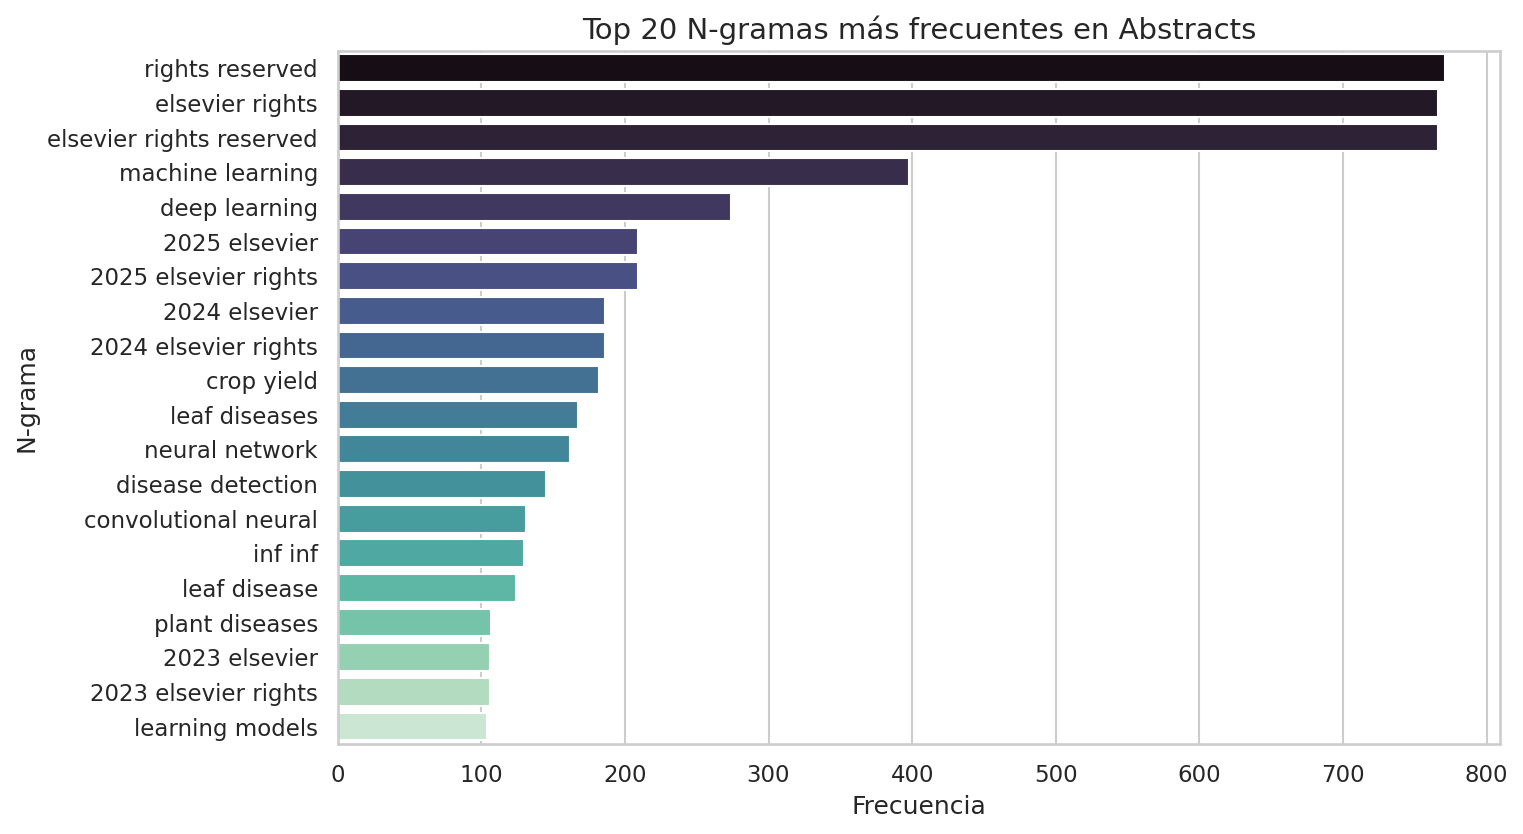

In [49]:
#N-gramas y términos en Abstracts
#Objetivo: encontrar frases comunes y términos recurrentes en los resúmenes.
# Unir todos los abstracts
abstracts = df['abstract'].fillna('').str.lower()

# N-gramas (2 y 3 palabras)
vectorizer = CountVectorizer(ngram_range=(2,3), stop_words='english').fit(abstracts)
X = vectorizer.transform(abstracts)
sum_words = X.sum(axis=0)

ngrams_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)[:20]

# DataFrame
ngram_df = pd.DataFrame(ngrams_freq, columns=['ngram', 'freq'])

# Visualizar
plt.figure(figsize=(10,6))
sns.barplot(y='ngram', x='freq', data=ngram_df, palette='mako')
plt.title("Top 20 N-gramas más frecuentes en Abstracts", fontsize=14)
plt.xlabel("Frecuencia")
plt.ylabel("N-grama")
plt.show()

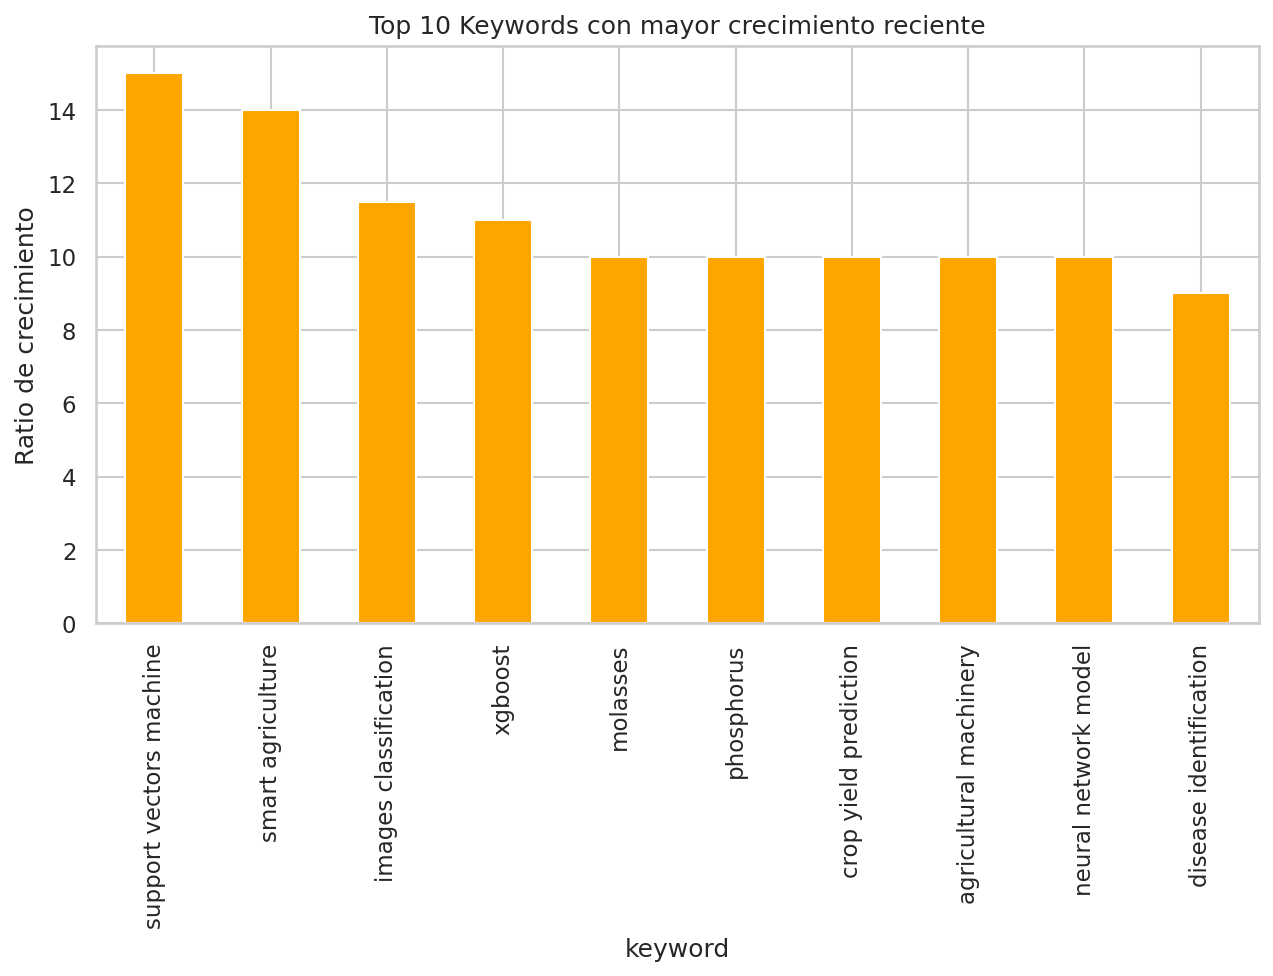

In [50]:
# Normalizamos año
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna(subset=['year'])

# Expandir keywords con año
rows = []
for _, row in df.iterrows():
    kws = (str(row['author_Keywords']) + ';' + str(row['index_keywords'])).split(';')
    for kw in kws:
        kw_clean = kw.strip().lower()
        if kw_clean:
            rows.append({'year': int(row['year']), 'keyword': kw_clean})

kw_year_df = pd.DataFrame(rows)

# Contar frecuencia por año
trend = kw_year_df.groupby(['keyword', 'year']).size().reset_index(name='count')

# Calcular crecimiento relativo (últimos 3 años vs resto)
latest_years = trend['year'].max() - 2
growth = (
    trend[trend['year'] >= latest_years]
    .groupby('keyword')['count'].sum()
    / trend[trend['year'] < latest_years]
    .groupby('keyword')['count'].sum()
)

growth = growth.sort_values(ascending=False).dropna().head(10)

# Visualizar crecimiento
growth.plot(kind='bar', figsize=(10,5), color='orange')
plt.title("Top 10 Keywords con mayor crecimiento reciente")
plt.ylabel("Ratio de crecimiento")
plt.show()

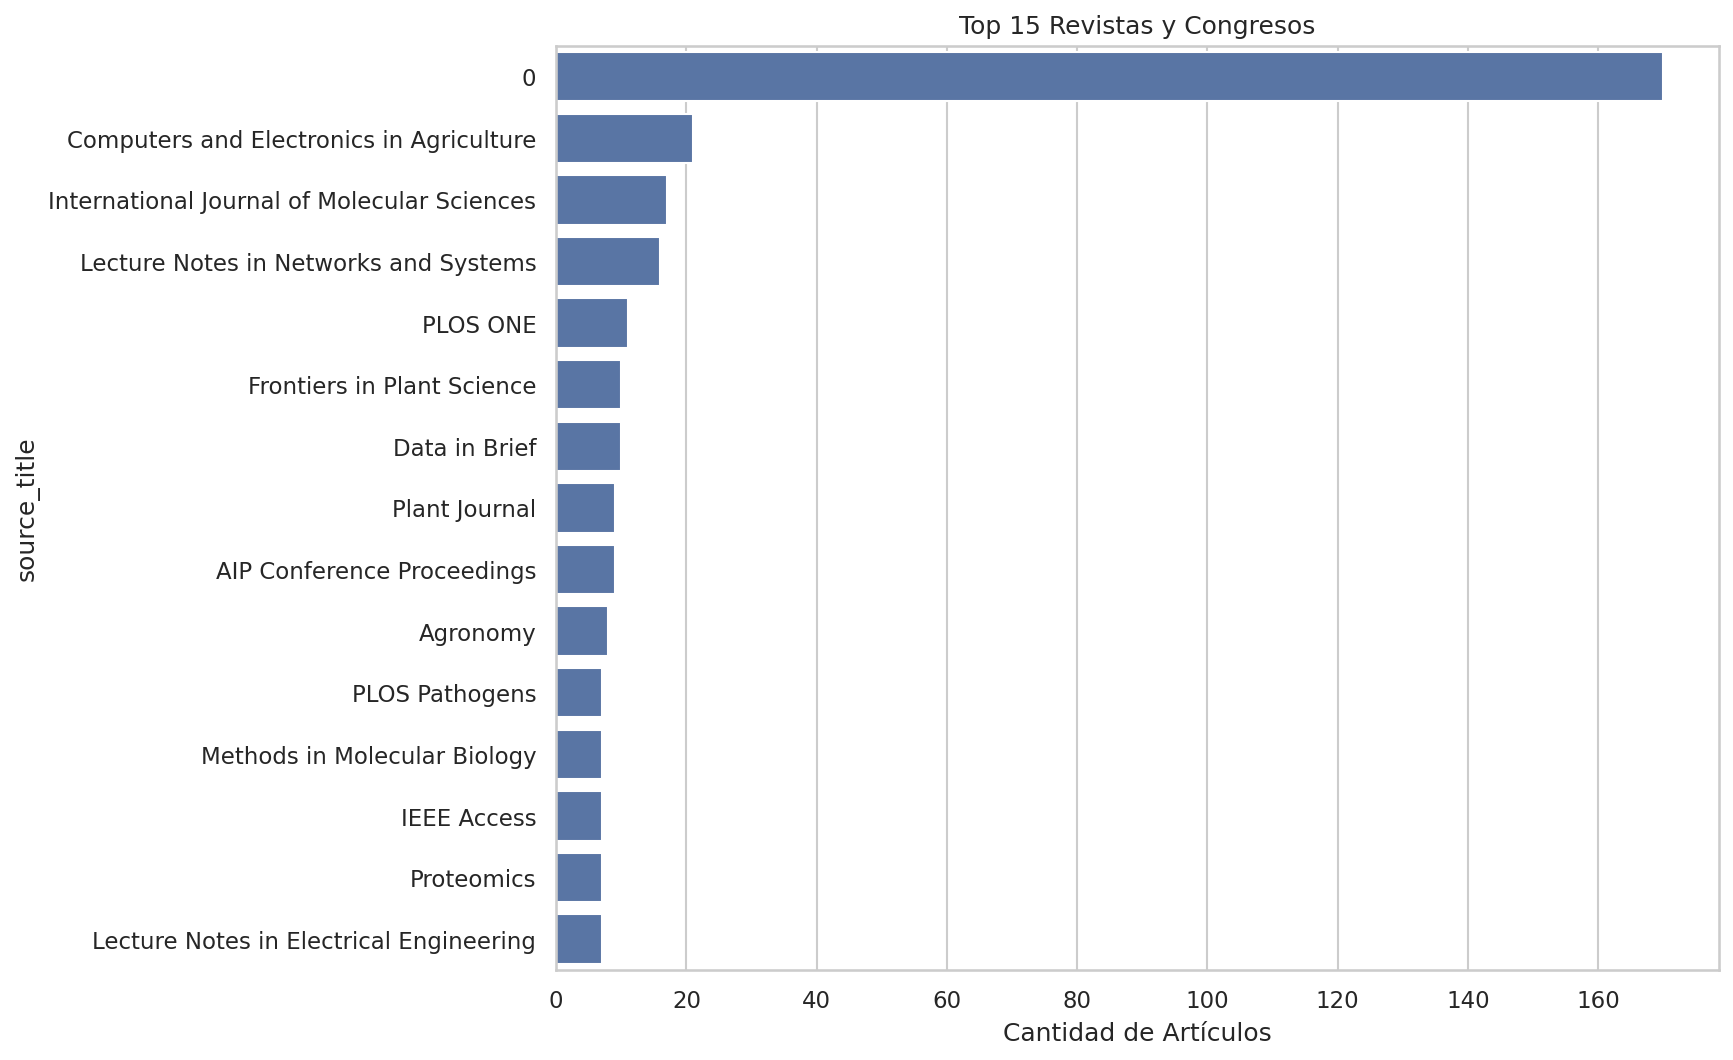

In [51]:
# Contar las 15 fuentes más comunes
top_sources = df['source_title'].value_counts().nlargest(15)

# Visualizar
plt.figure(figsize=(10, 8))
sns.barplot(x=top_sources.values, y=top_sources.index, orient='h')
plt.title('Top 15 Revistas y Congresos')
plt.xlabel('Cantidad de Artículos')
plt.show()

In [50]:
# Define el número de tópicos que quieres encontrar (esto es un hiperparámetro clave)
num_topics = 10 # Empezamos con 10 como una suposición educada

# Crea y entrena el modelo LDA
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

,n_components,10
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


In [75]:
# Comparación entre el DataFrame original y el enriquecido con CrossRef para algunos DOIs
import requests
import pandas as pd

# Seleccionar algunos DOIs del DataFrame original
dois_ejemplo = unified_df['DOI'].dropna().unique()[:5]  # Cambia el número para más DOIs

# Función para consultar CrossRef
def get_crossref_metadata(doi):
    url = f"https://api.crossref.org/works/{doi}"
    try:
        r = requests.get(url)
        if r.status_code == 200:
            data = r.json()['message']
            return {
                'DOI': data.get('DOI'),
                'title': data.get('title', [''])[0],
                'authors': ', '.join([a.get('family','') for a in data.get('author',[])]),
                'year': data.get('issued',{}).get('date-parts',[[None]])[0][0],
                'source_title': data.get('container-title', [''])[0],
                'volume': data.get('volume',''),
                'issue': data.get('issue',''),
                'page_start': data.get('page','').split('-')[0] if data.get('page') else '',
                'page_end': data.get('page','').split('-')[-1] if data.get('page') else '',
                'abstract': data.get('abstract','')
            }
        else:
            return None
    except Exception as e:
        return None

# Construir DataFrame enriquecido
crossref_data = [get_crossref_metadata(doi) for doi in dois_ejemplo]
crossref_df = pd.DataFrame([d for d in crossref_data if d])

# Comparar ambos DataFrames DOI por DOI
for doi in dois_ejemplo:
    print(f"\nDOI: {doi}")
    print("Original:")
    print(unified_df[unified_df['DOI']==doi][['title','authors','year','source_title']].to_string(index=False))
    print("CrossRef:")
    print(crossref_df[crossref_df['DOI']==doi][['title','authors','year','source_title']].to_string(index=False))
    crossref_df


DOI: 10.1016/j.compag.2025.110865
Original:
                                                                                                    title                                                                                                                                                     authors  year                             source_title
Non-invasive diagnosis of nutrient deficiencies in winter wheat and winter rye using UAV-based RGB images J., Yi, Jinhui; G., Lopez, Gina; S., Hadir, Sofia; J., Weyler, Jan; L., Klingbeil, Lasse; M., Deichmann, Marion; J., Gall, Juergen; S.J., Seidel, Sabine J.  2025 Computers and Electronics in Agriculture
CrossRef:
                                                                                                    title                                                      authors  year                             source_title
Non-invasive diagnosis of nutrient deficiencies in winter wheat and winter rye using UAV-based RGB images Yi, Lop